# 0.0 Imports

In [1]:
import math
import datetime
import pandas   as pd
import numpy    as np
import seaborn  as sns
import xgboost  as xgb
import inflection
import random
import warnings
import pickle

import matplotlib.pyplot as plt
from scipy import stats as ss
from boruta import BorutaPy
from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

## 0.1 Helper Functions

In [90]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
        mae_list = []
        mape_list=[]
        rmse_list=[]
        for k in reversed( range(1, kfold+1) ):
            if verbose:
                print( '\nKFold Number: {}' .format(k) )
            # Start and End date for validation
            validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
            validation_end_date =  x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
            
            # filtering dataset
            
            training = x_training[x_training['date'] < validation_start_date]
            validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
            
            # training and validation dataset
            
            # training
            xtraining = training.drop( ['date', 'sales'], axis=1 )
            ytraining = training['sales']
            # validation
            xvalidation = validation.drop( ['date', 'sales'], axis=1 )
            yvalidation = validation['sales']
            
            # model
            m = model.fit( xtraining, ytraining )
            # prediction
            yhat = m.predict( xvalidation )
            # performance
            m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) ) 
            # store performance of each kfold iteration
            mae_list.append(m_result['MAE'])
            mape_list.append(m_result['MAPE'])
            rmse_list.append(m_result['RMSE'])
    
        return pd.DataFrame({'Model Name': model_name,
                      'MAE CV': np.round( np.mean(mae_list),2 ).astype( str ) + ' +/- ' + np.round( np.std(mae_list),2 ).astype(str),
                      'MAPE CV': np.round( np.mean(mape_list),2 ).astype( str ) + ' +/- ' + np.round( np.std(mape_list),2 ).astype(str),
                      'RMSE CV': np.round( np.mean(rmse_list),2 ).astype( str ) + ' +/- ' + np.round( np.std(rmse_list),2 ).astype(str)}, index=[0])

def mean_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat) / y ) )
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def ml_error (model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE' : mae,
                          'MAPE' : mape,
                          'RMSE': rmse}, index=[0] )


def jupyter_settings():
    
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def cramer_v( x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k, = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1) ) )

In [91]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos Dados 

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
         'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

# rename

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Columns: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA 

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)    
#promo2_since_week            
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#promo2_since_year              
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar',4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'  }

df1['promo_interval'].fillna(0, inplace= True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [12]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

#promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]','int32'])

### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency  - mean, median 
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Breno\AppData\Local\Temp\ipykernel_5740\3775197481.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'] )


<Axes: xlabel='competition_distance', ylabel='Density'>

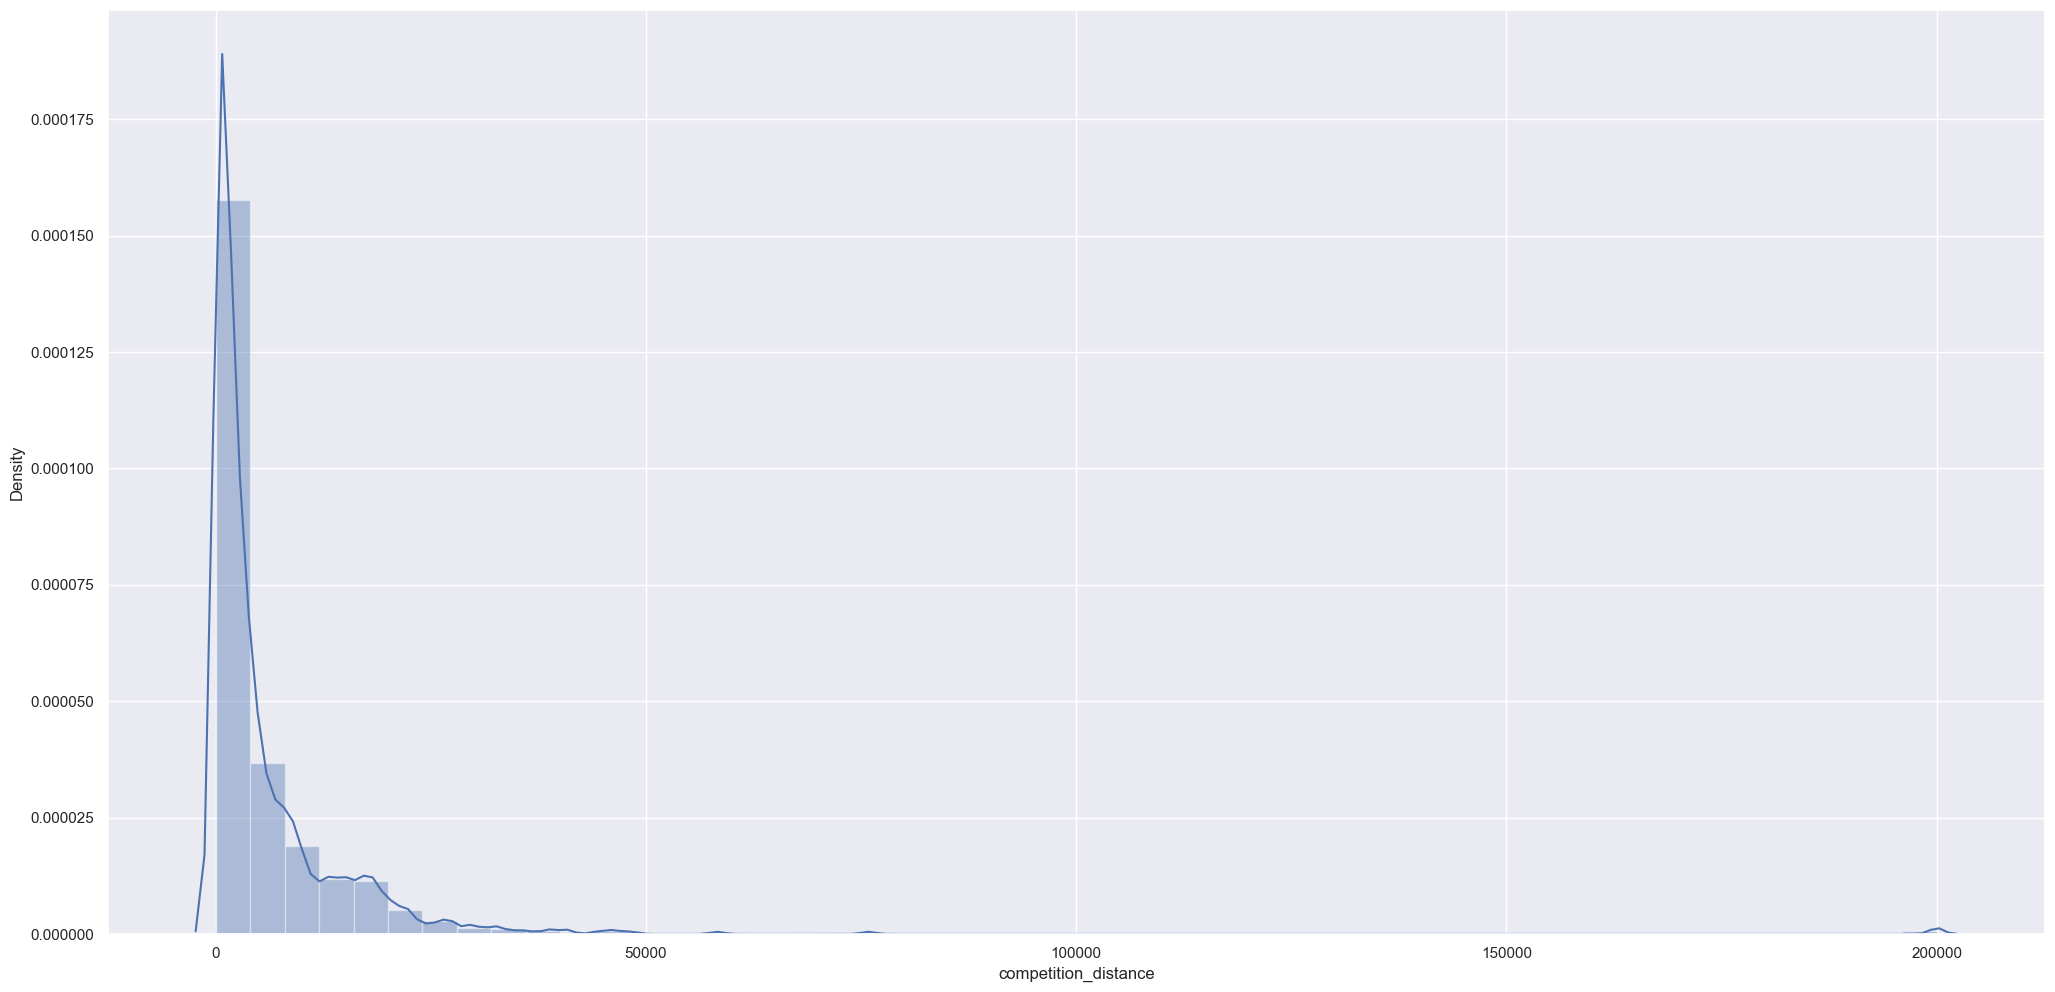

In [15]:
sns.distplot( df1['competition_distance'] )

### 1.7.2 Category Attributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

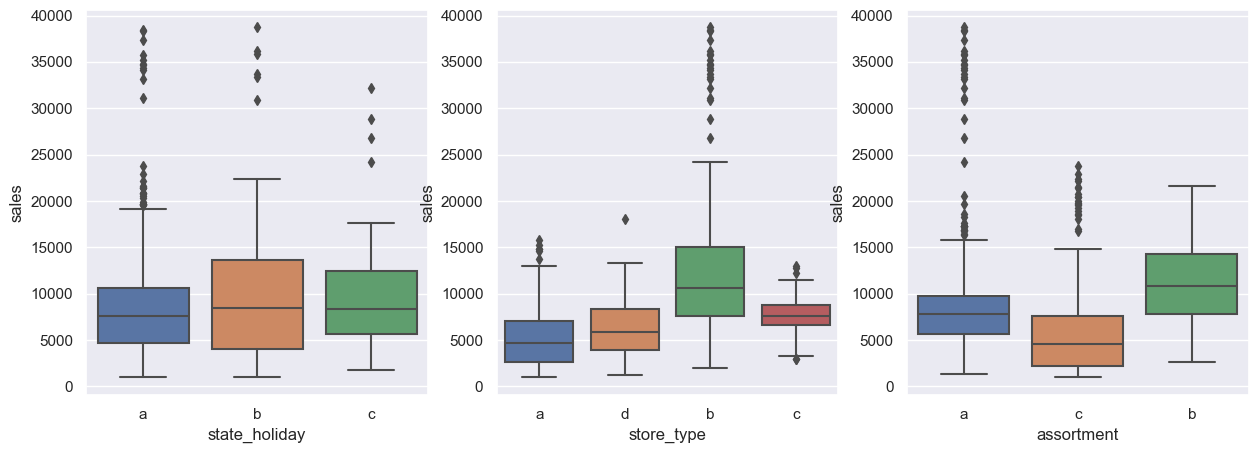

In [17]:
# Definindo o tamanho da figura
plt.figure(figsize=(15, 5))

# Selecionando os dados
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Criando os subplots e boxplots
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# Mostrando os gráficos
plt.show()

# 2.0 Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

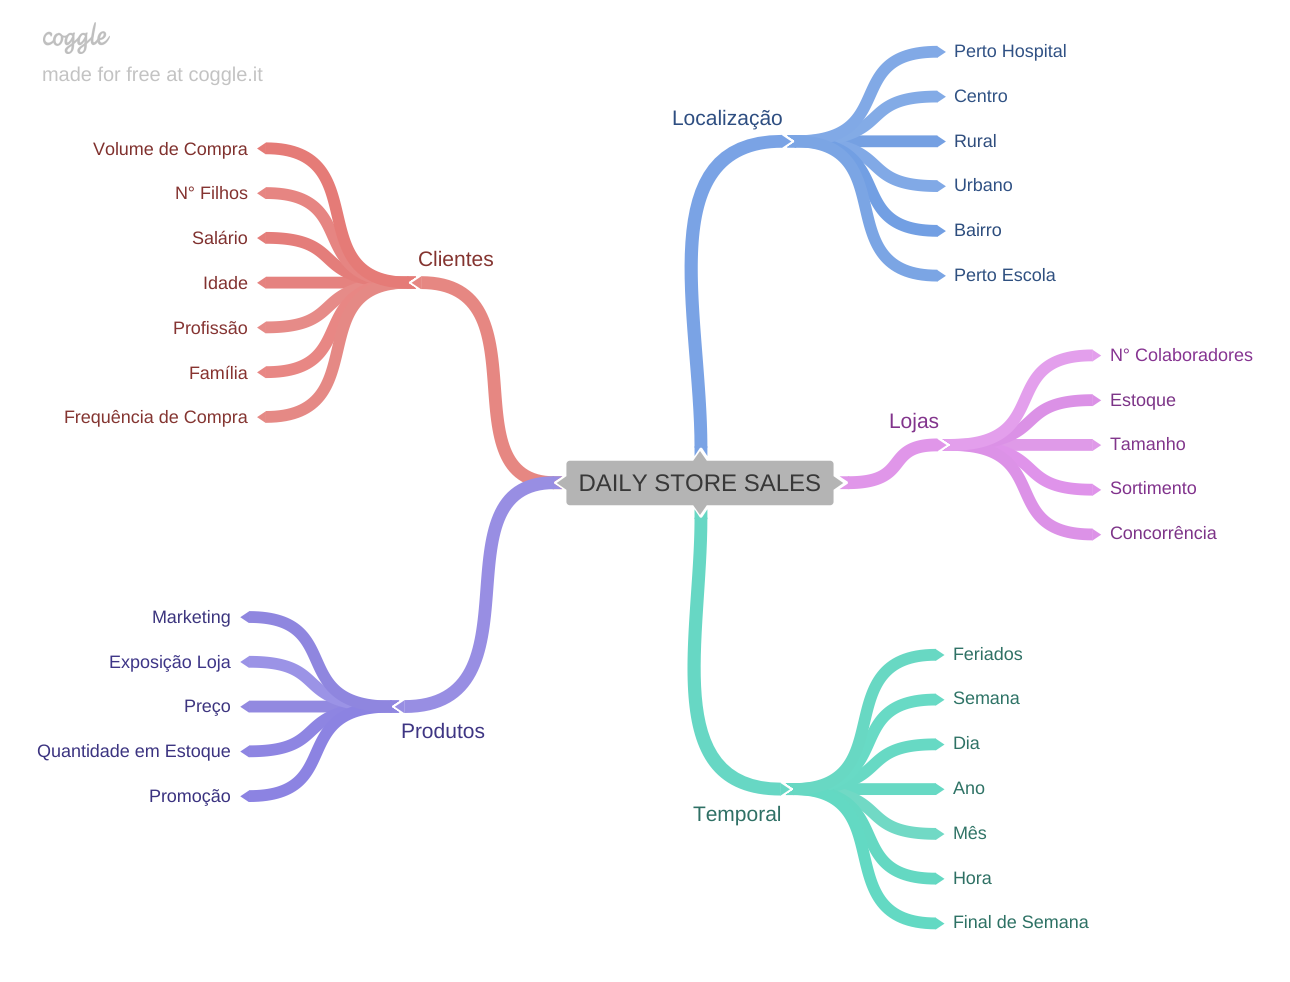

In [19]:
Image('img/MindMapHyphotesis.png')

## 2.2 Criação das Hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de colaboradores, deveriam vender mais.

**2.** Lojas com maior capacidade de estoque, deveriam vender mais.

**3.** Lojas com maior porte, deveriam vender mais.

**4.** Lojas com maior sortimento, deveriam vender mais.

**5.** Lojas com competidores mais próximos, deveriam vender mais.

**6.** Lojas com competidores à mais tempo, deveriam vender mais.


### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing, deveriam vender mais.

**2.** Lojas que expõem melhor os produtos nas vitrines, deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos, deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo, deveriam vender mais.

**5.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo, deveriam vender mais.

**7.** Lojas com mais dias de promoção, deveriam vender mais.

**8.** Lojas com mais promoções consecutivas, deveriam vender mais.


### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal, deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento, deveriam vender mais.

**2.** Lojas com competidores mais próximos, deveriam vender menos.

**3.** Lojas com competidores à mais tempo, deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo, deveriam vender mais.

**5.** Lojas com mais dias de promoção, deveriam vender mais.

**6.** Lojas com mais promoções consecutivas, deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal, deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype( int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime (x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days ).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtragem de Variáveis

In [21]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )

# 4.0 Análise Explorátoria dos Dados

In [24]:
df4 = df3.copy()

## 4.1 Análise Univariáda

### 4.1.1 Response Variable

C:\Users\Breno\AppData\Local\Temp\ipykernel_5740\3439622439.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], kde=False);


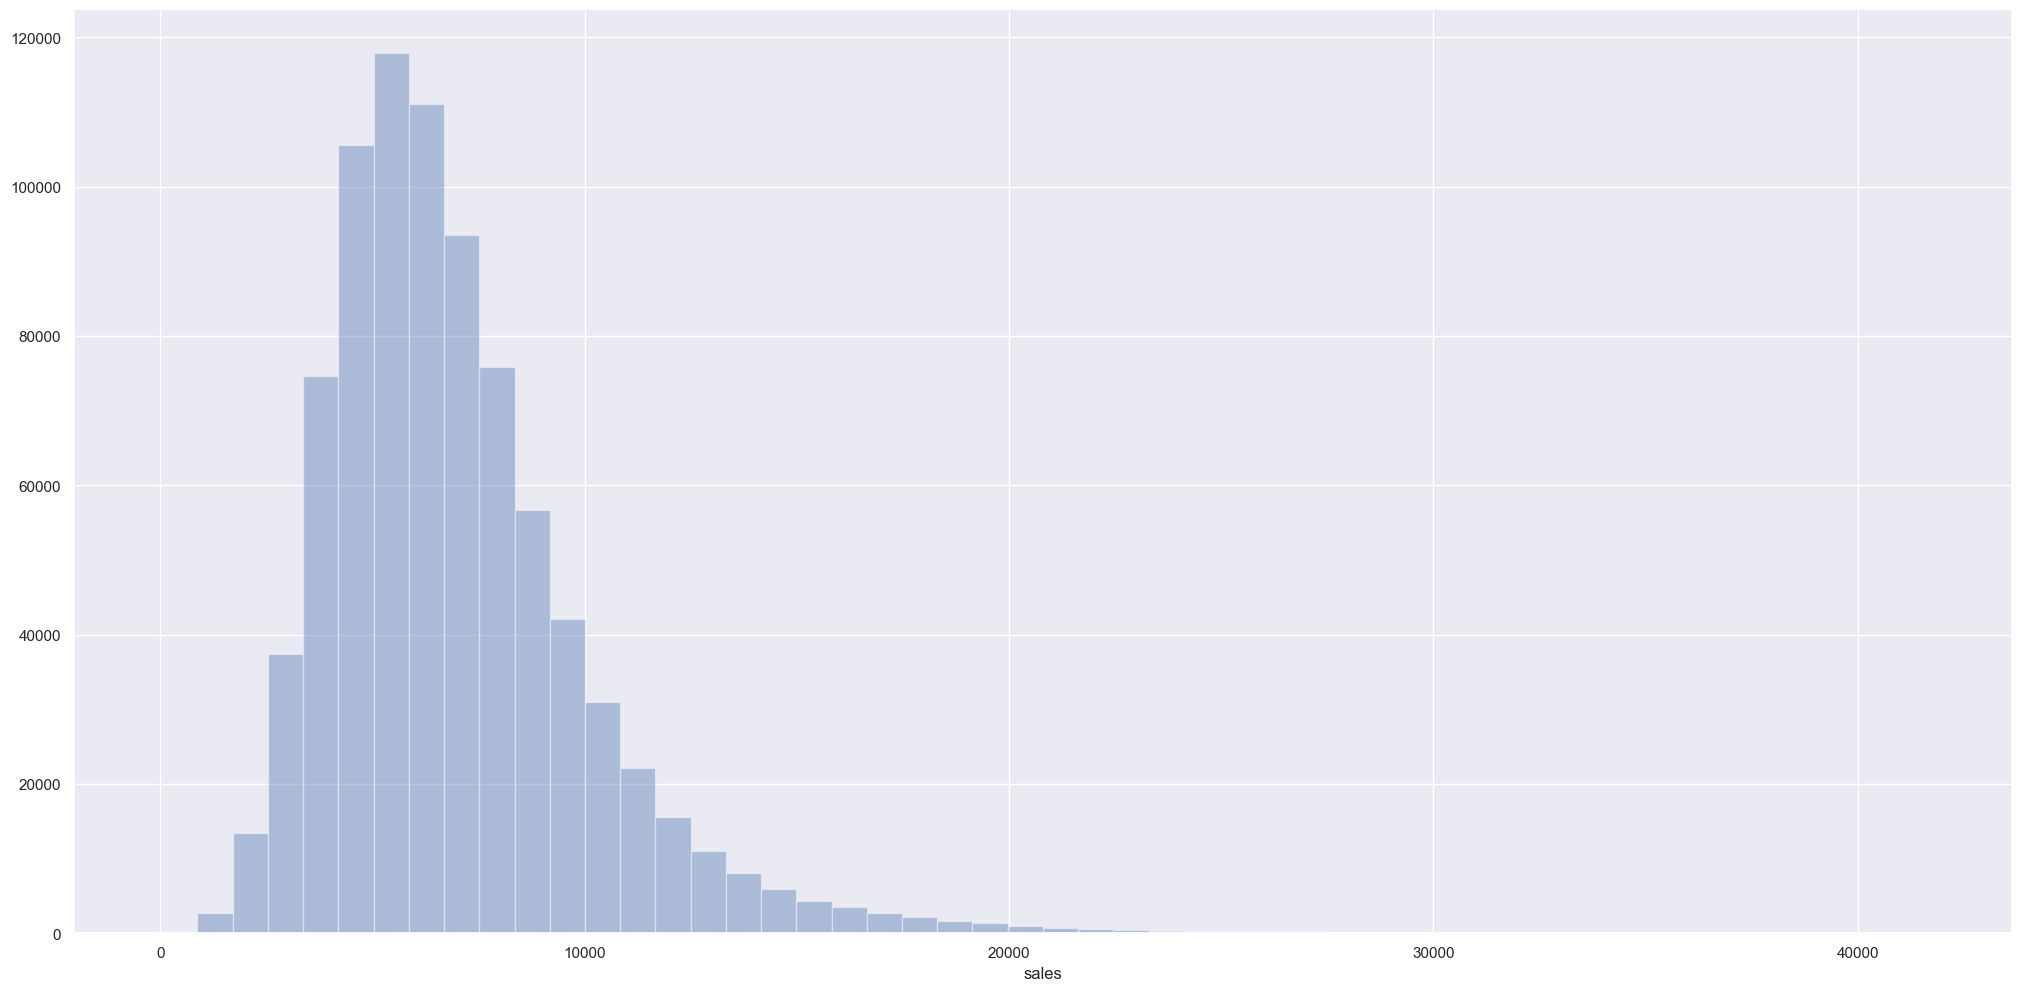

In [25]:
sns.distplot(df4['sales'], kde=False);

### 4.1.2 Numerical Variable

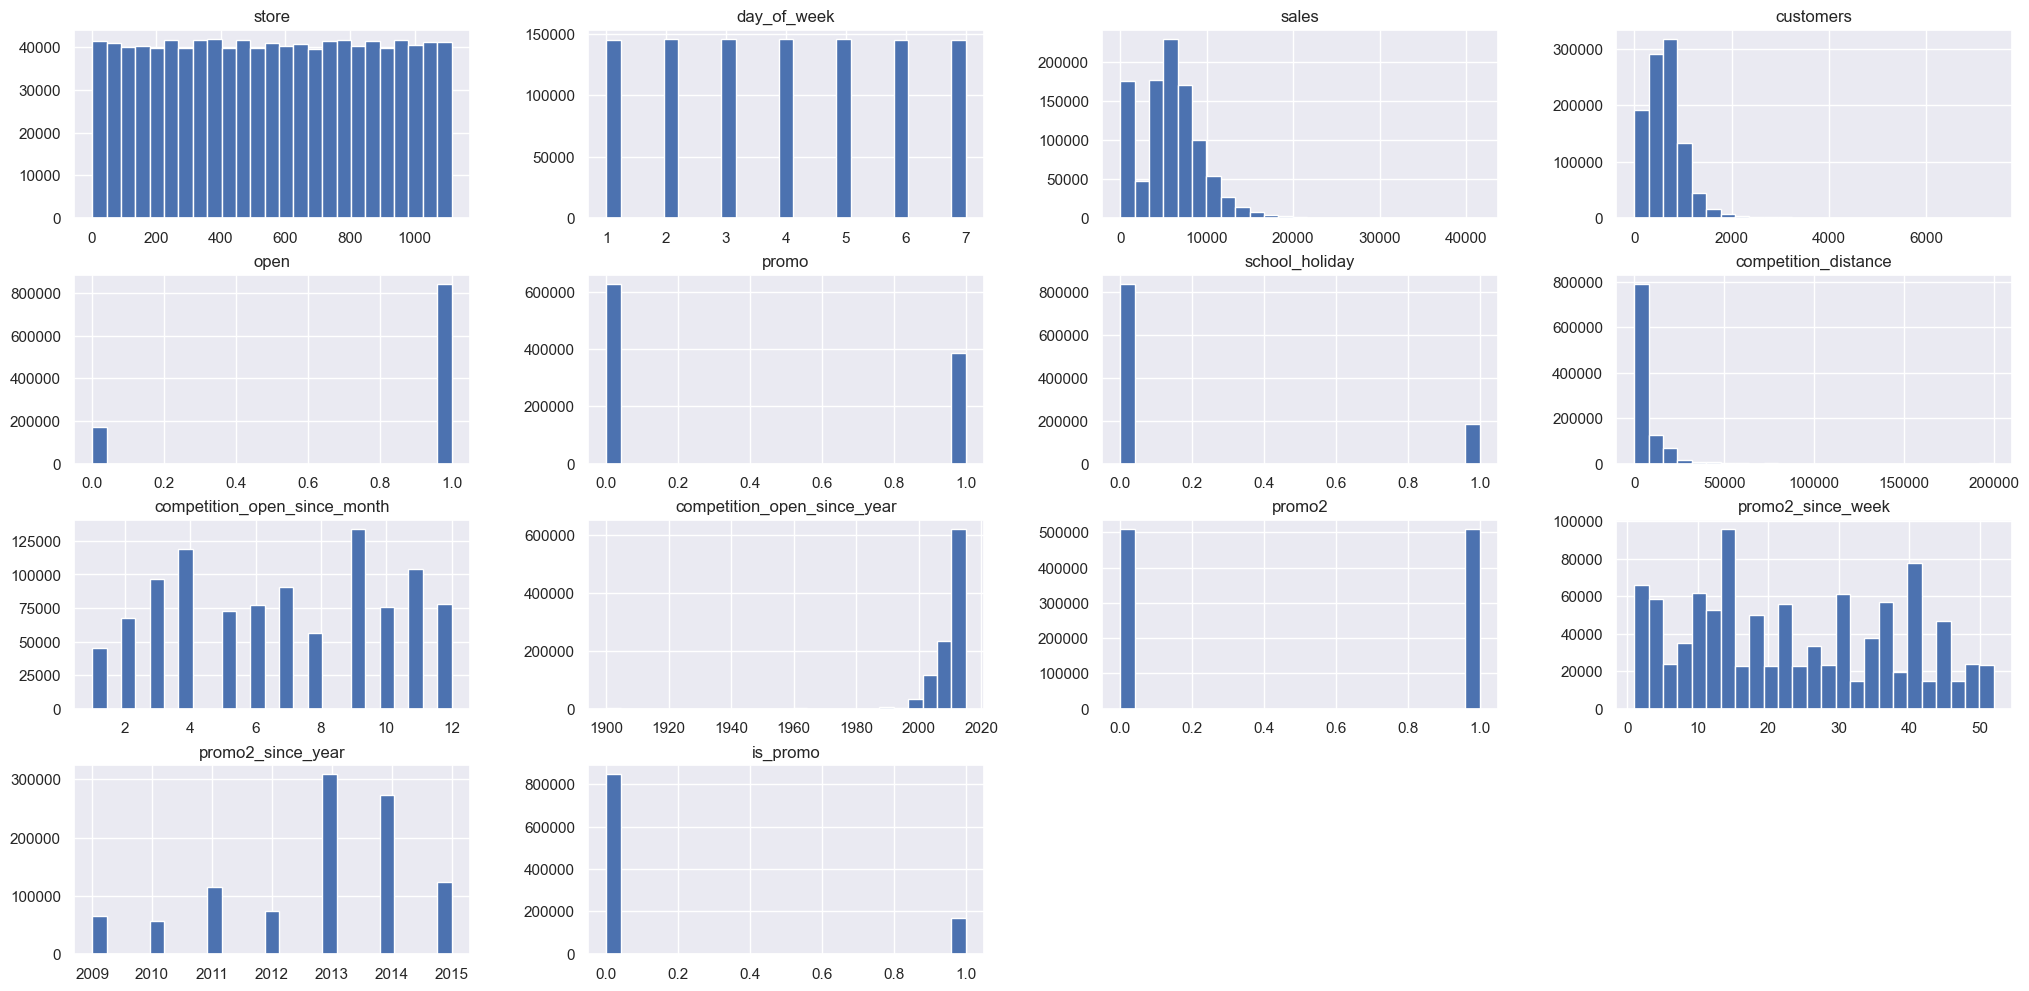

In [26]:
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

In [27]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

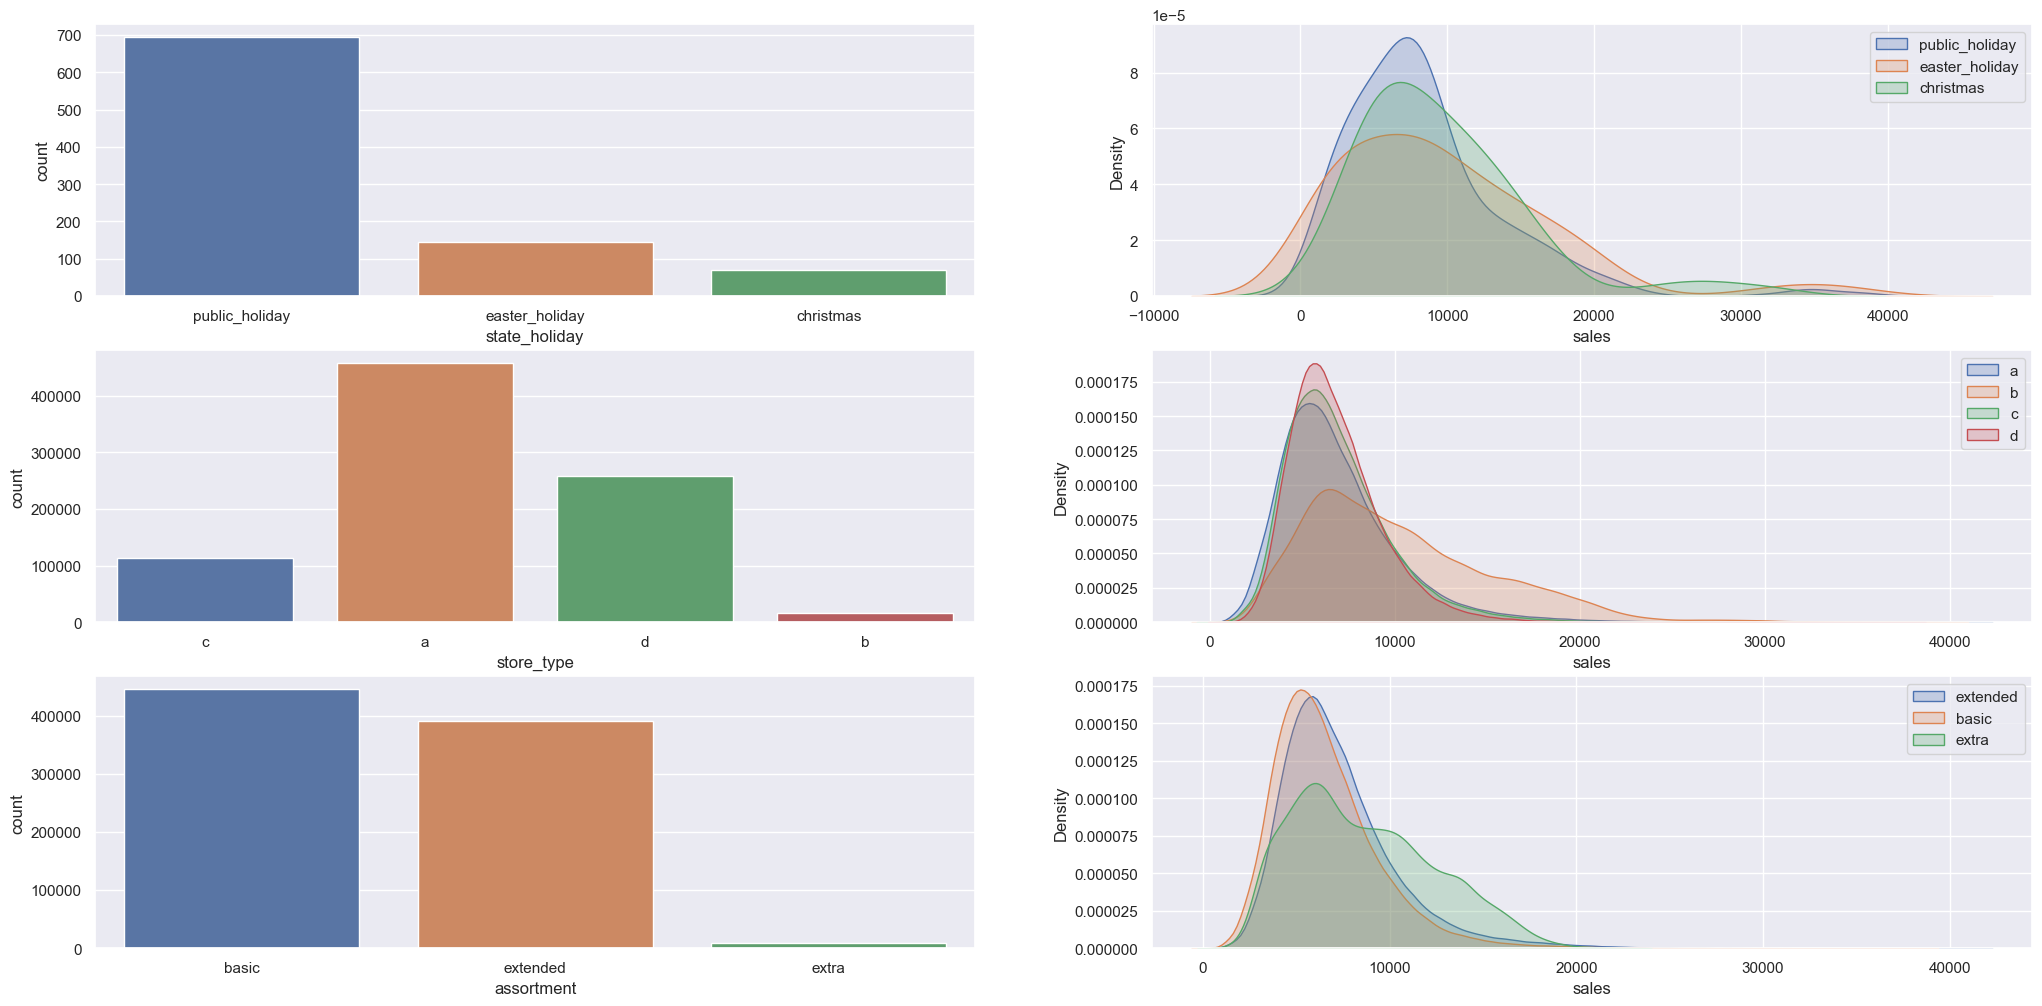

In [28]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x= a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday' ,fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday' ,fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas' ,fill = True)
plt.legend()
# store_type
plt.subplot( 3, 2, 3 )
sns.countplot(x=df4['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a' ,fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='b' ,fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='c' ,fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='d' ,fill = True)
plt.legend()

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot(x=df4['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label='extended' ,fill = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label='basic' ,fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label='extra' ,fill = True)
plt.legend()

## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento, deveriam vender mais.
**VERDADE**



<Axes: xlabel='year_week'>

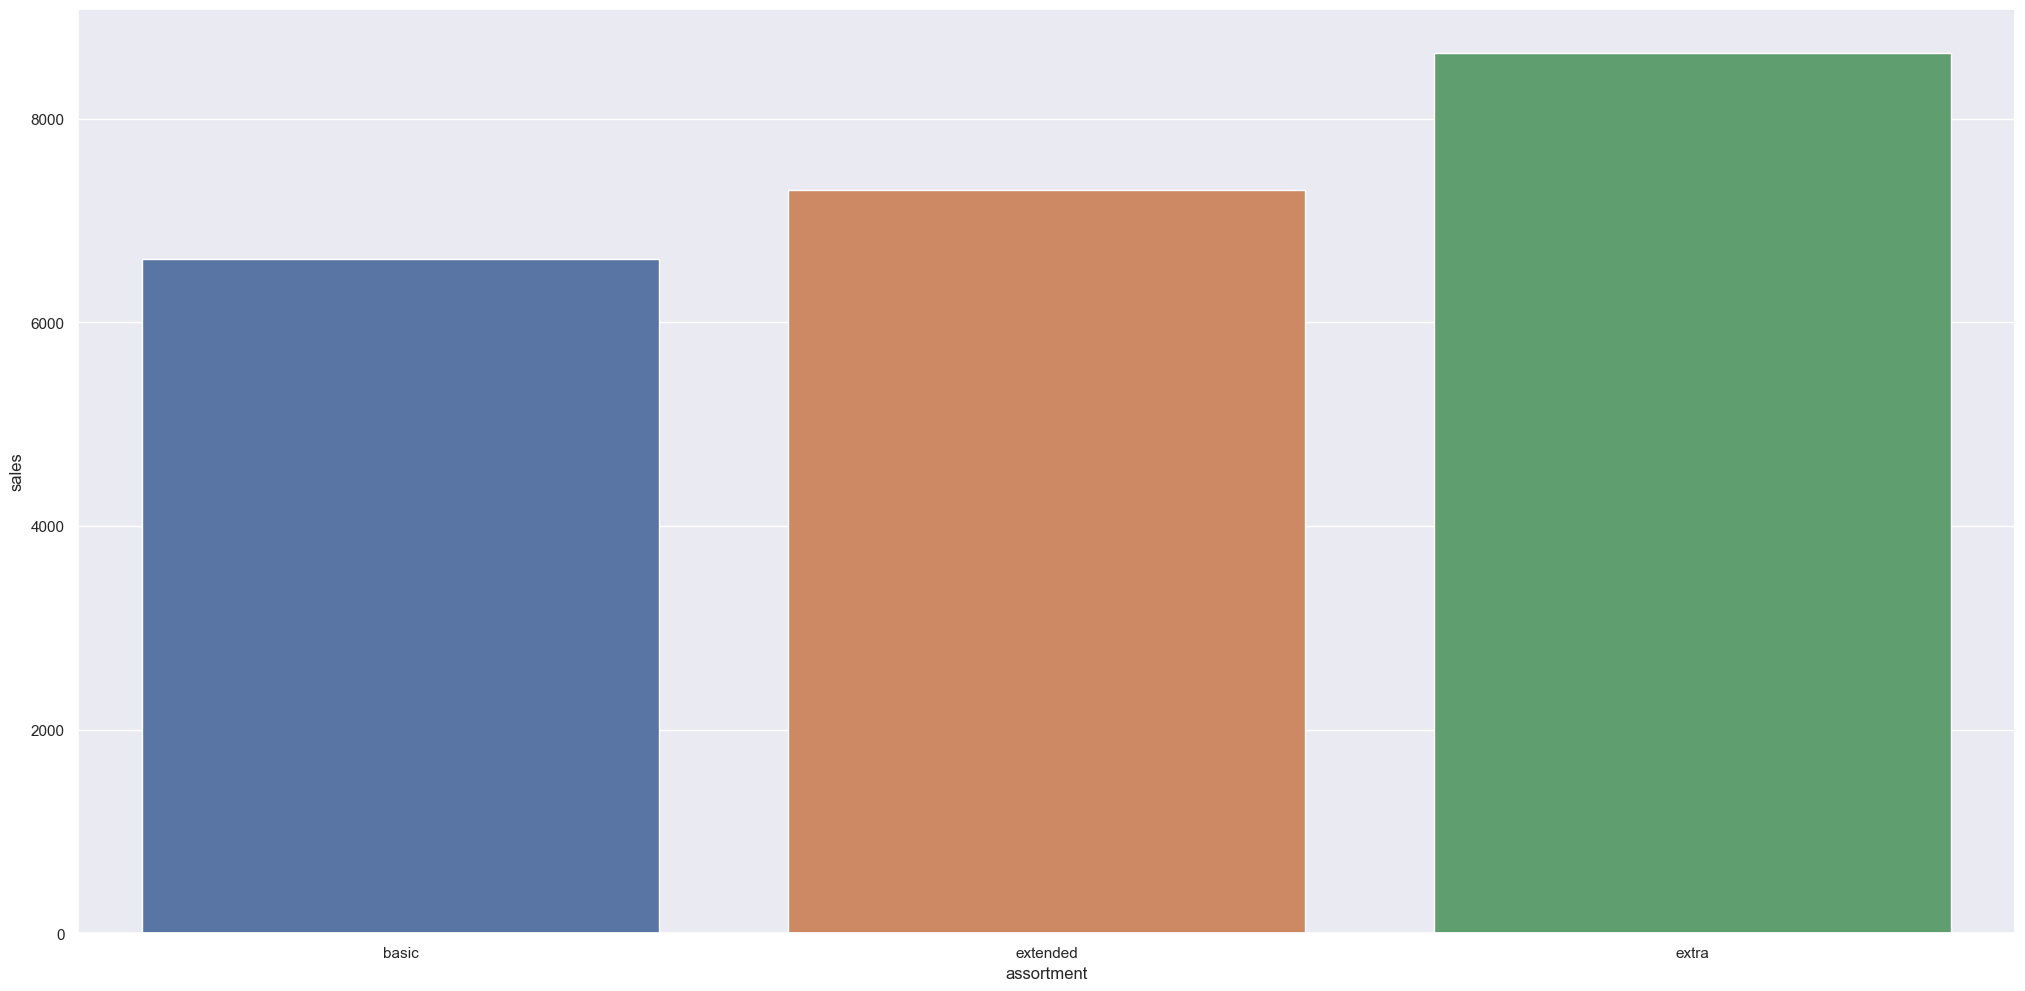

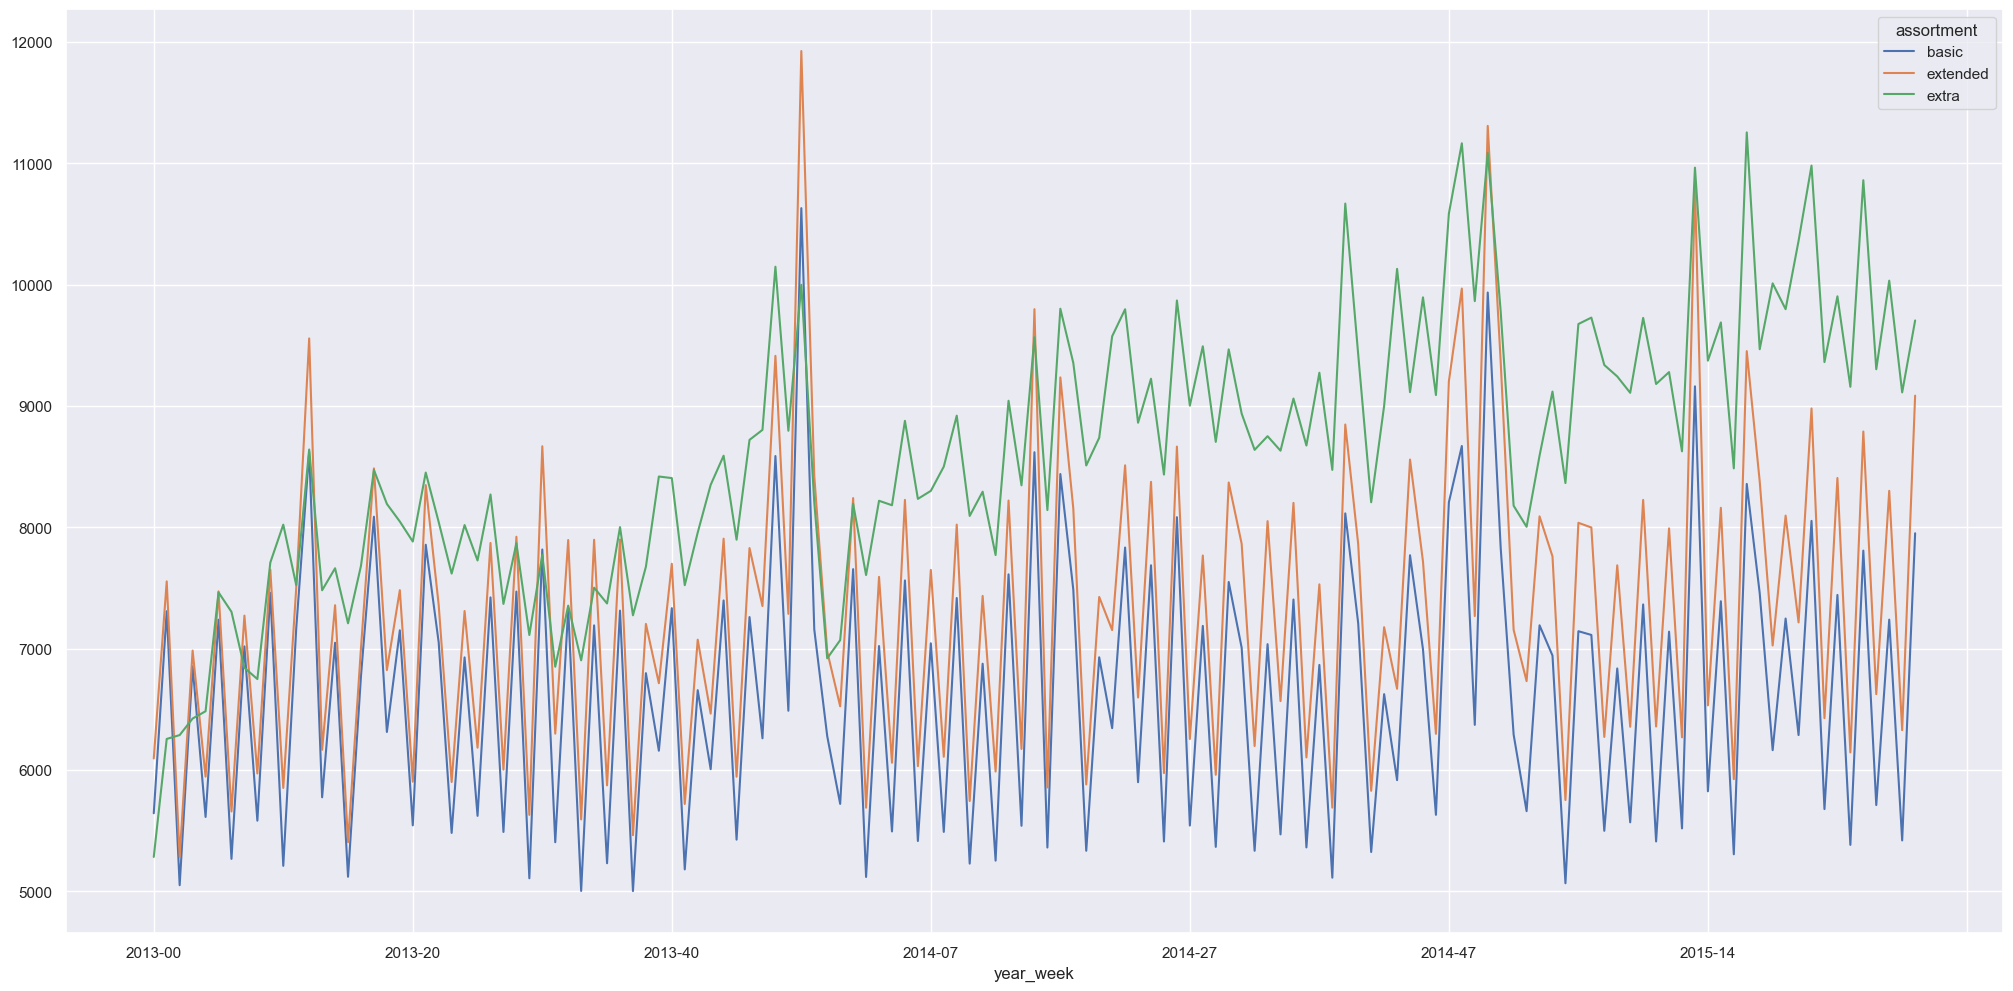

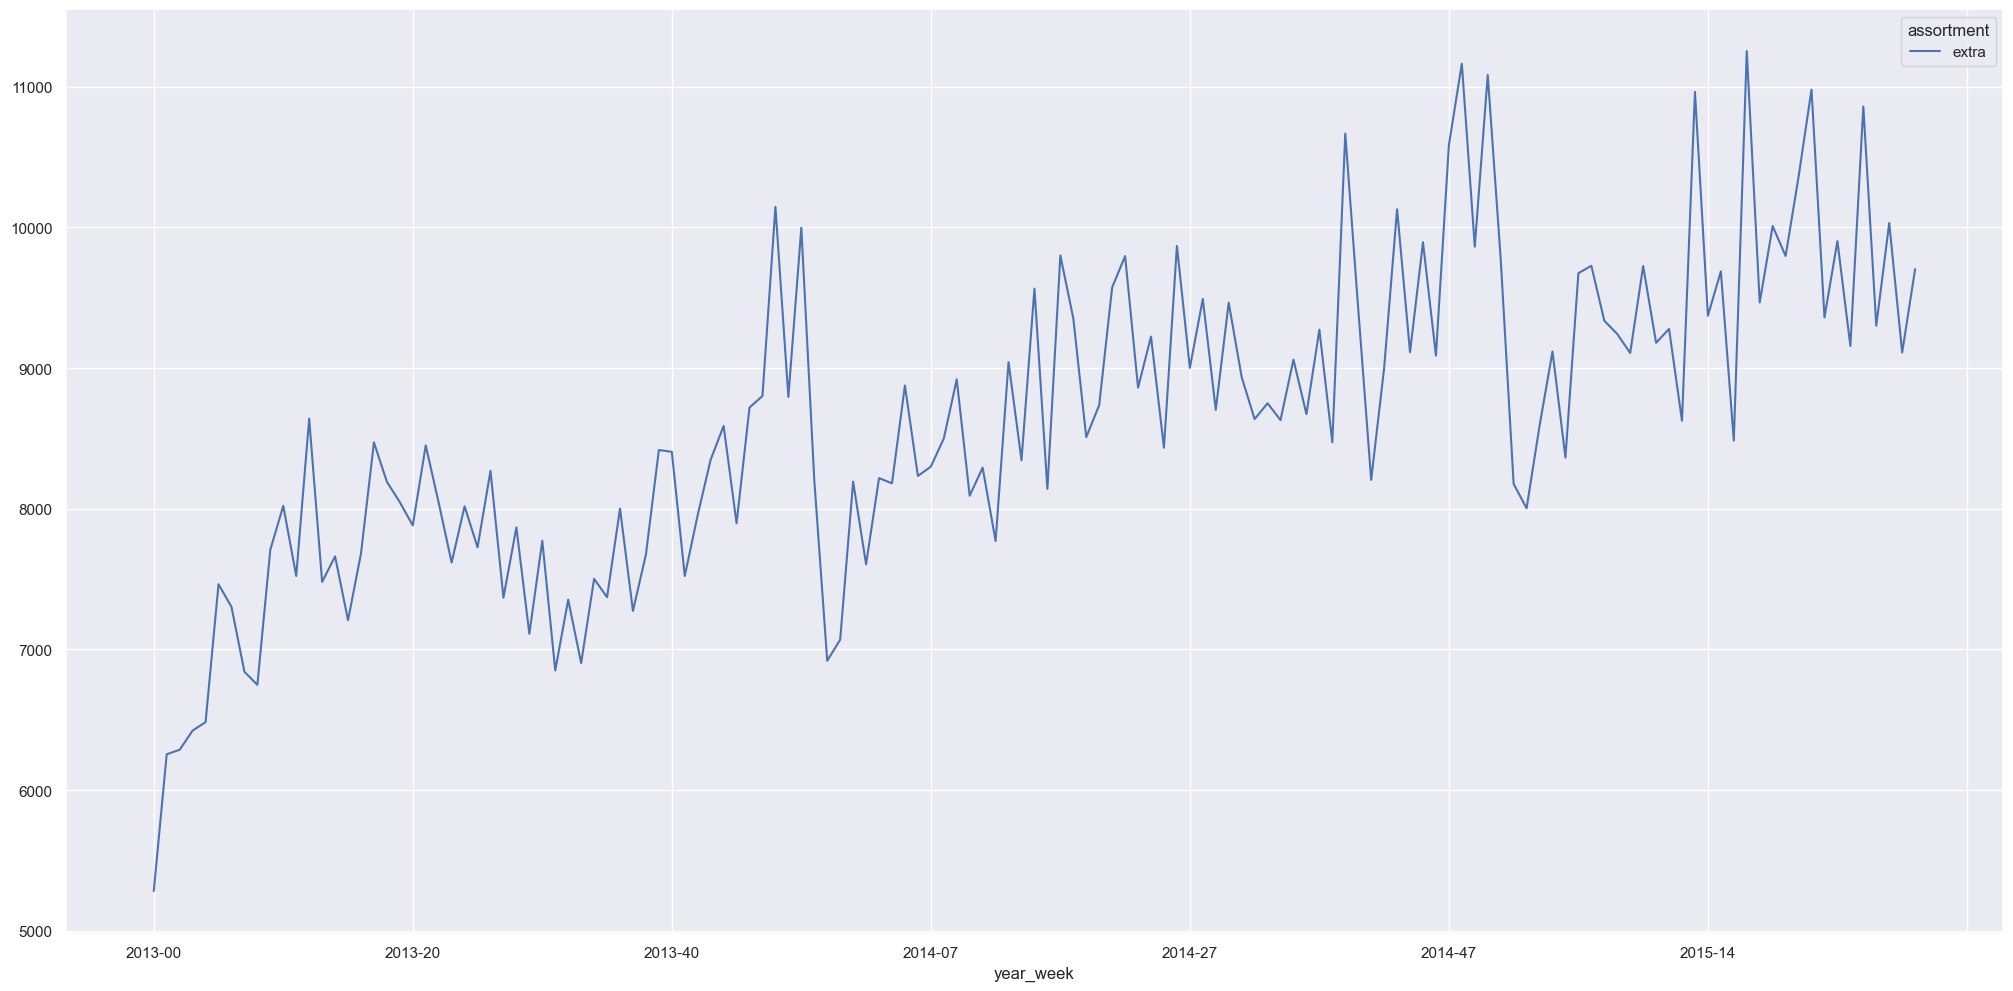

In [29]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()

sns.barplot( x='assortment', y='sales', data= aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index= 'year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']

aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot()


### **H2.** Lojas com competidores mais próximos, deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.



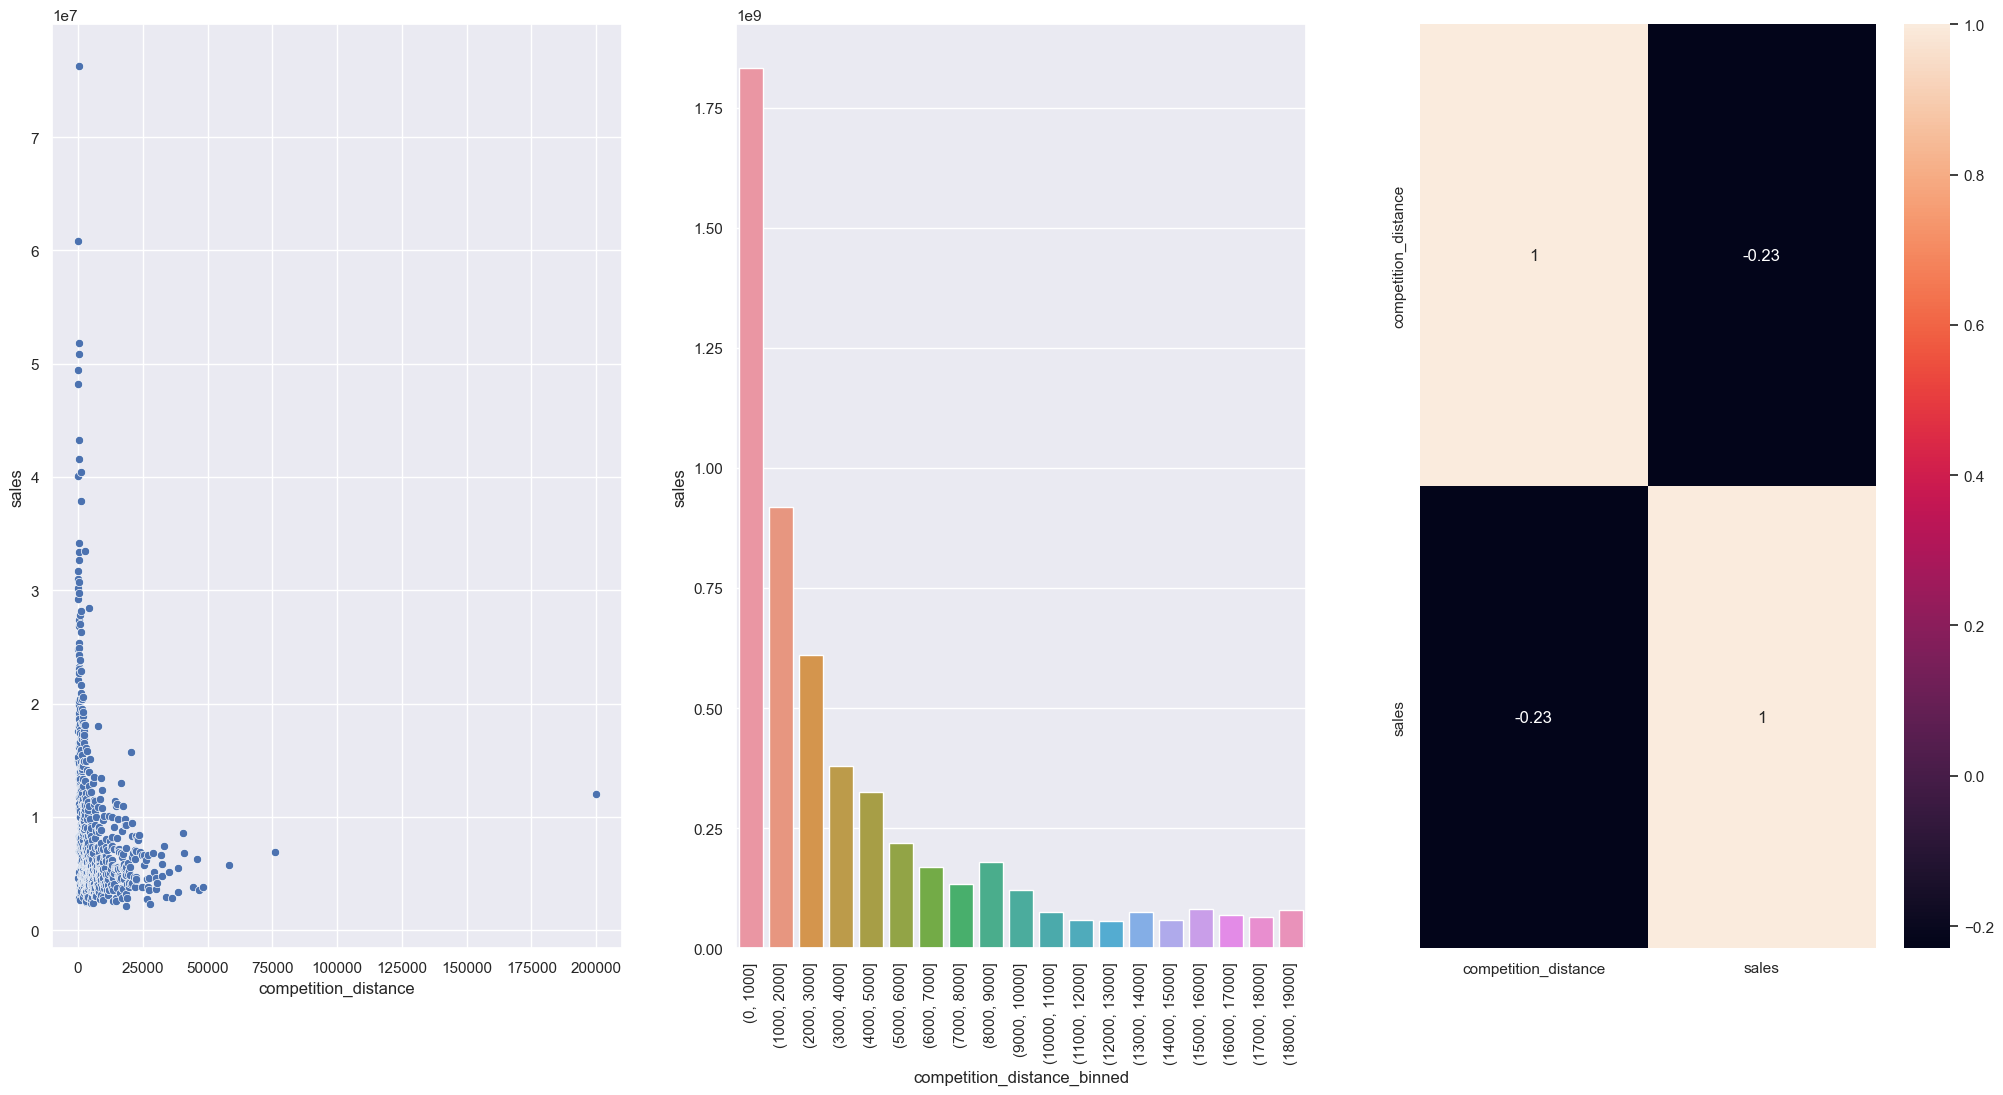

In [30]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y= 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data = aux2);

plt.xticks(rotation = 90);
plt.subplot(1, 3, 3)

# Selecionar apenas as colunas numéricas para o cálculo da correlação
numeric_columns = aux1.select_dtypes(include=['float64', 'int64']).columns

# Calcular a matriz de correlação apenas para as colunas numéricas
correlation_matrix = aux1[numeric_columns].corr(method='pearson')

# Plotar a matriz de correlação
sns.heatmap(correlation_matrix, annot=True);

### **H3.** Lojas com competidores à mais tempo, deveriam vender mais.
**FALSA** Lojas com COMPETIDORES à mais tempo vendem MENOS.

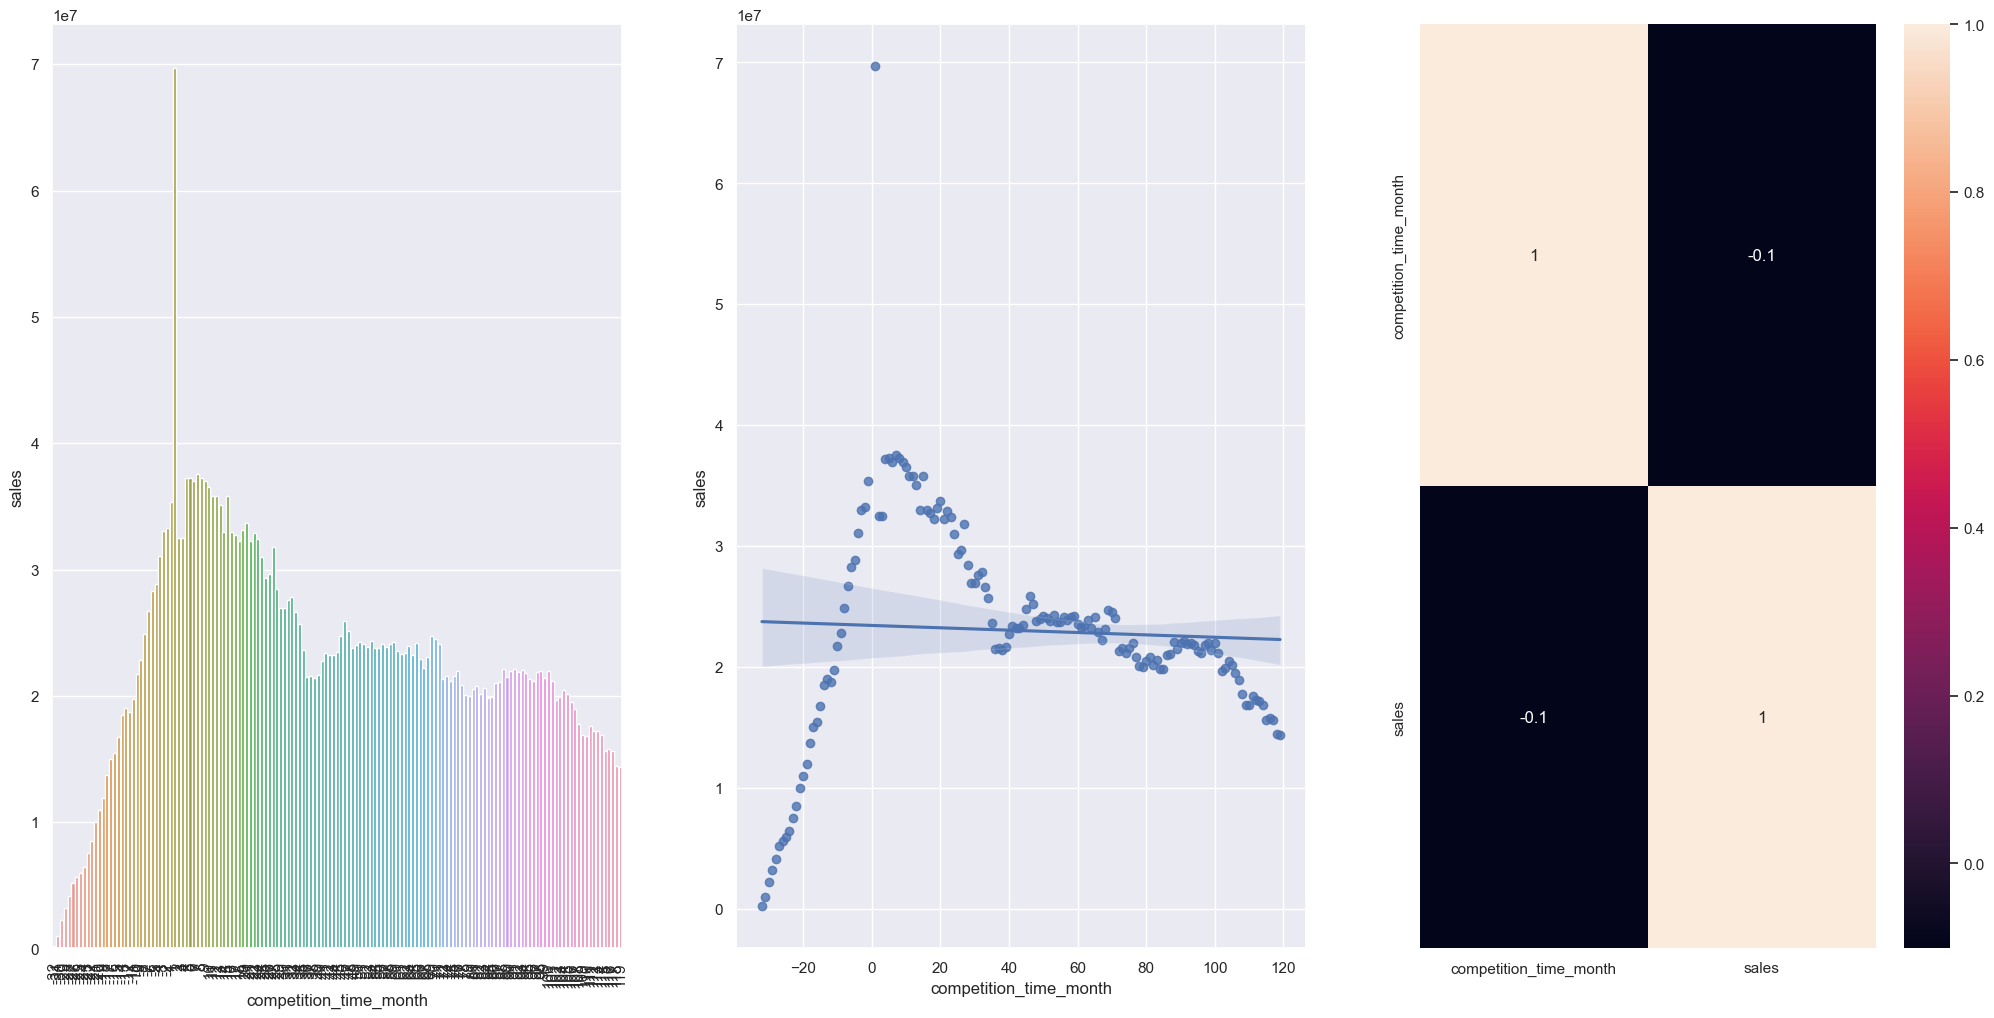

In [31]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month',y='sales', data= aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month',y='sales', data= aux2);

plt.subplot(1, 3, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True);




### **H4.** Lojas com promoções ativas por mais tempo, deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

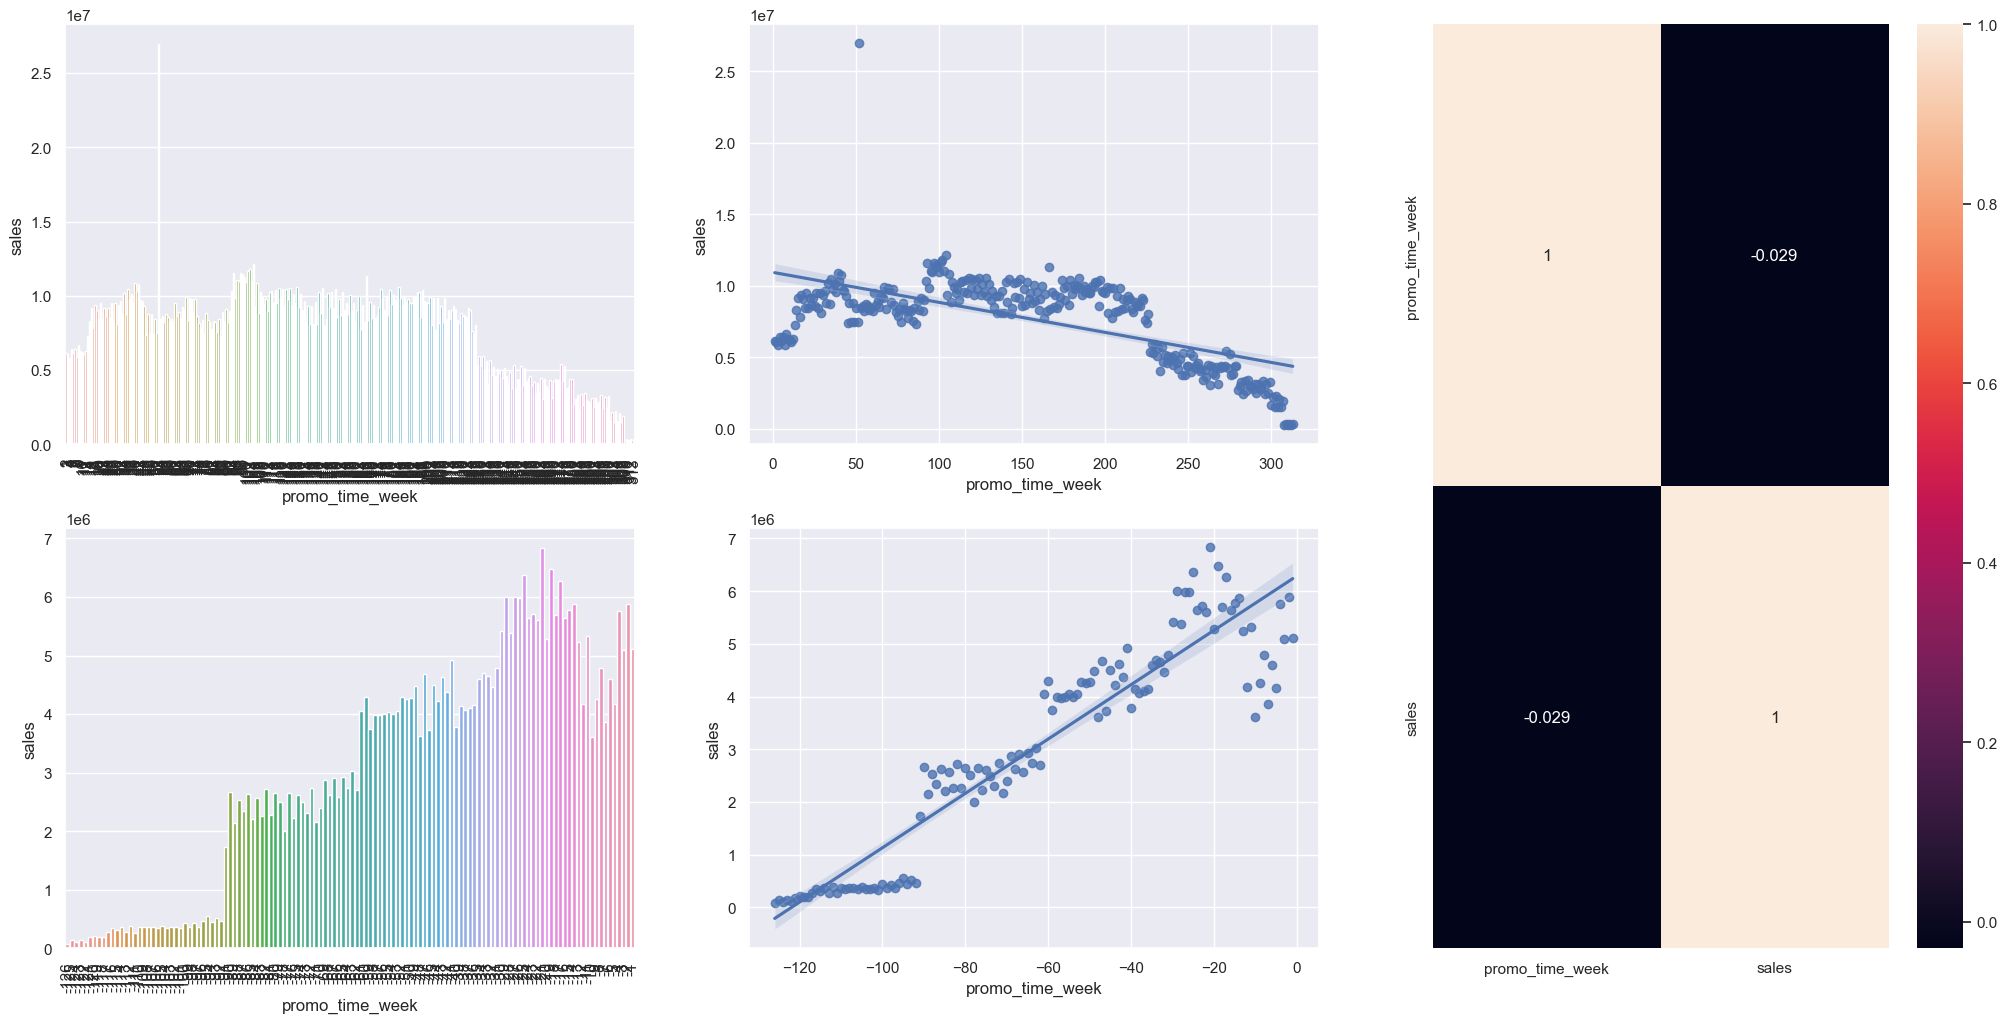

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3)


plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x= 'promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x= 'promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x= 'promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x= 'promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr( method='pearson'), annot=True);

### <s>**H5.** Lojas com mais dias de promoção, deveriam vender mais.<s>

### **H6.** Lojas com mais promoções consecutivas, deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas, vendem menos

In [33]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


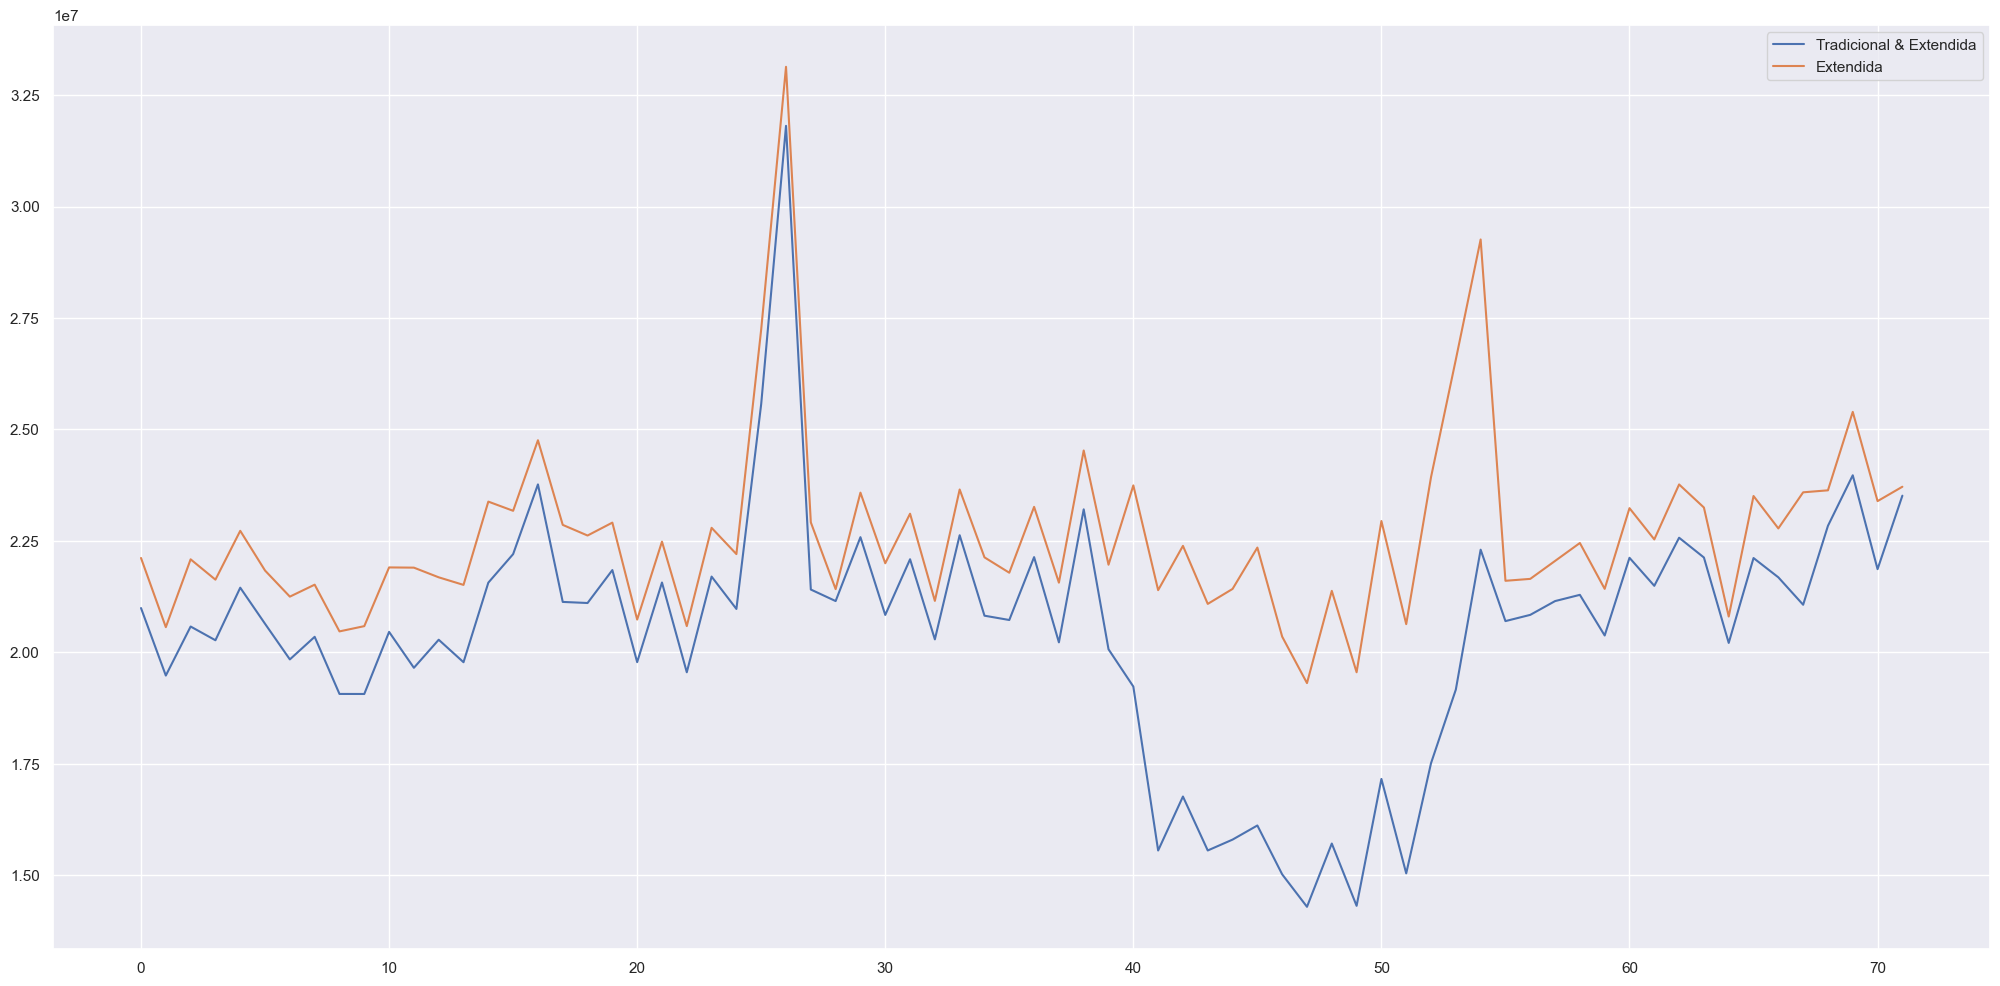

In [34]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend(labels=['Tradicional & Extendida', 'Extendida'] )

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** Porque lojas abertas durante o feriado do Natal vendem menos.

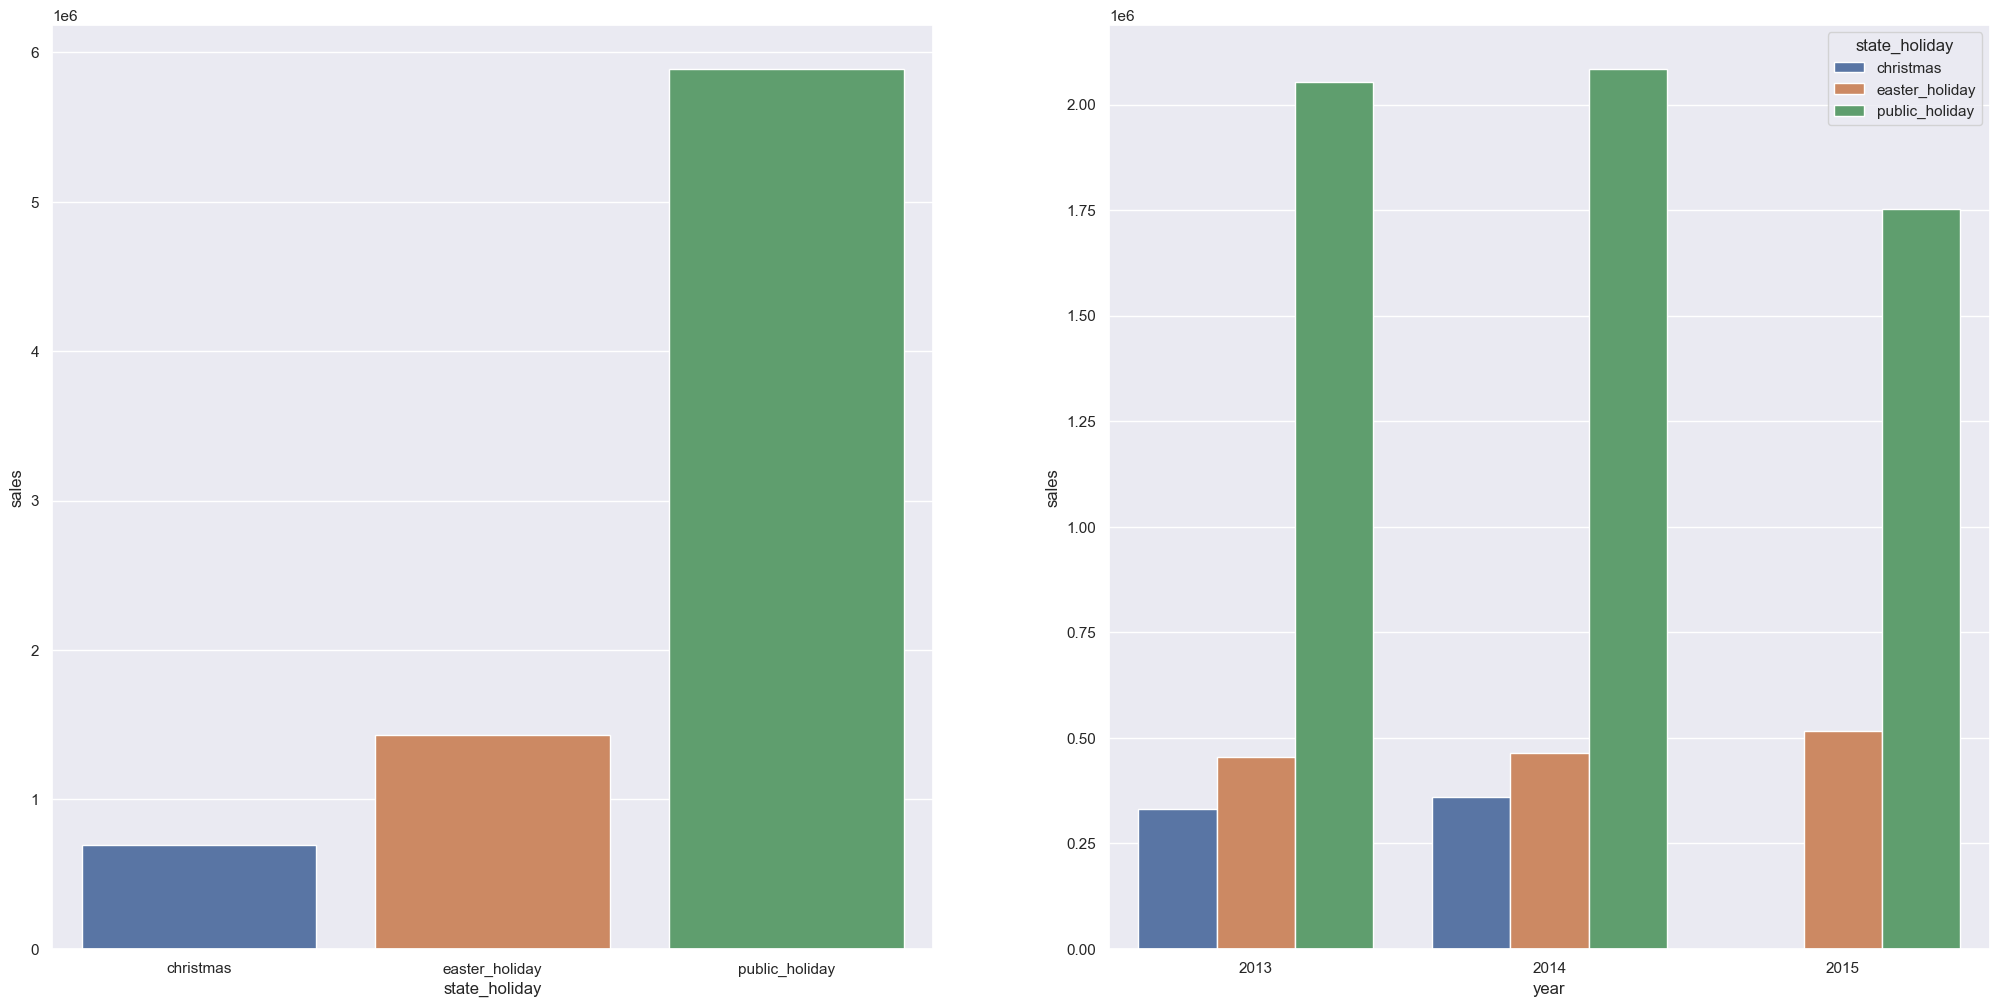

In [35]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.


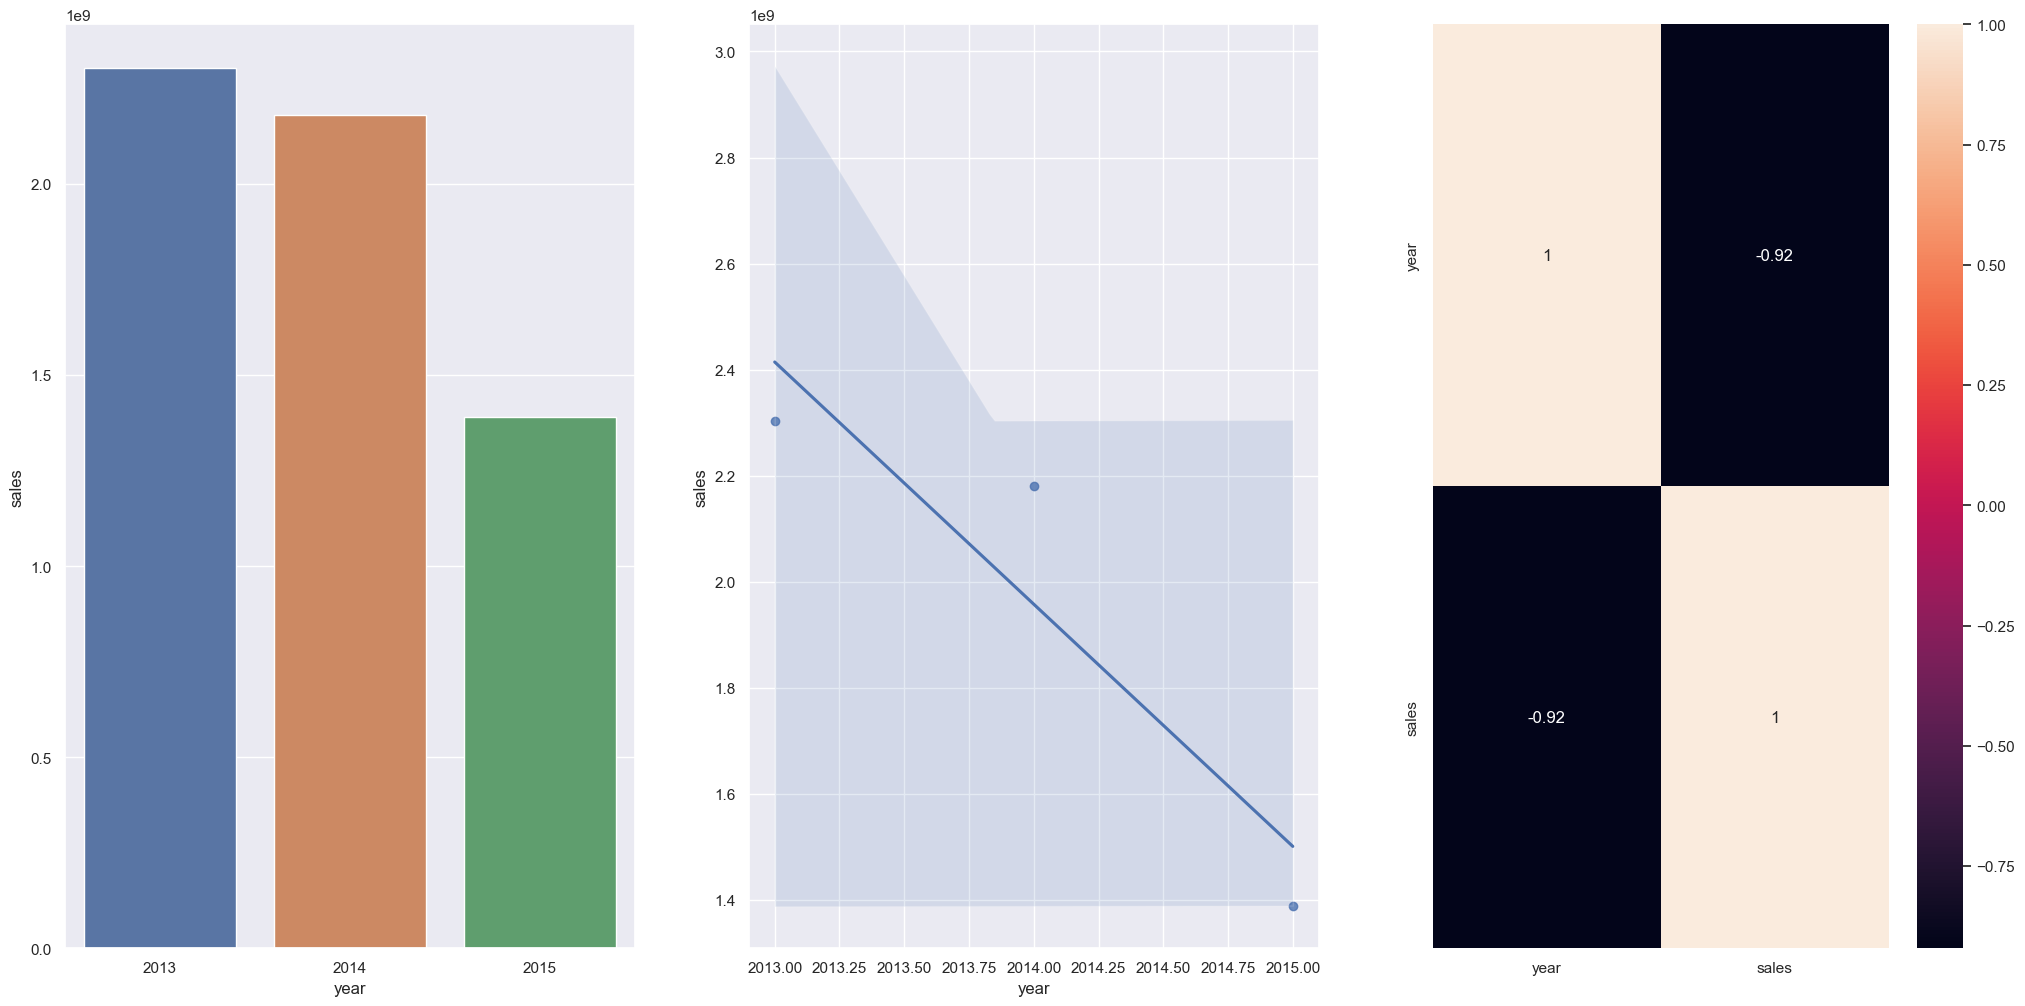

In [36]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method ='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano


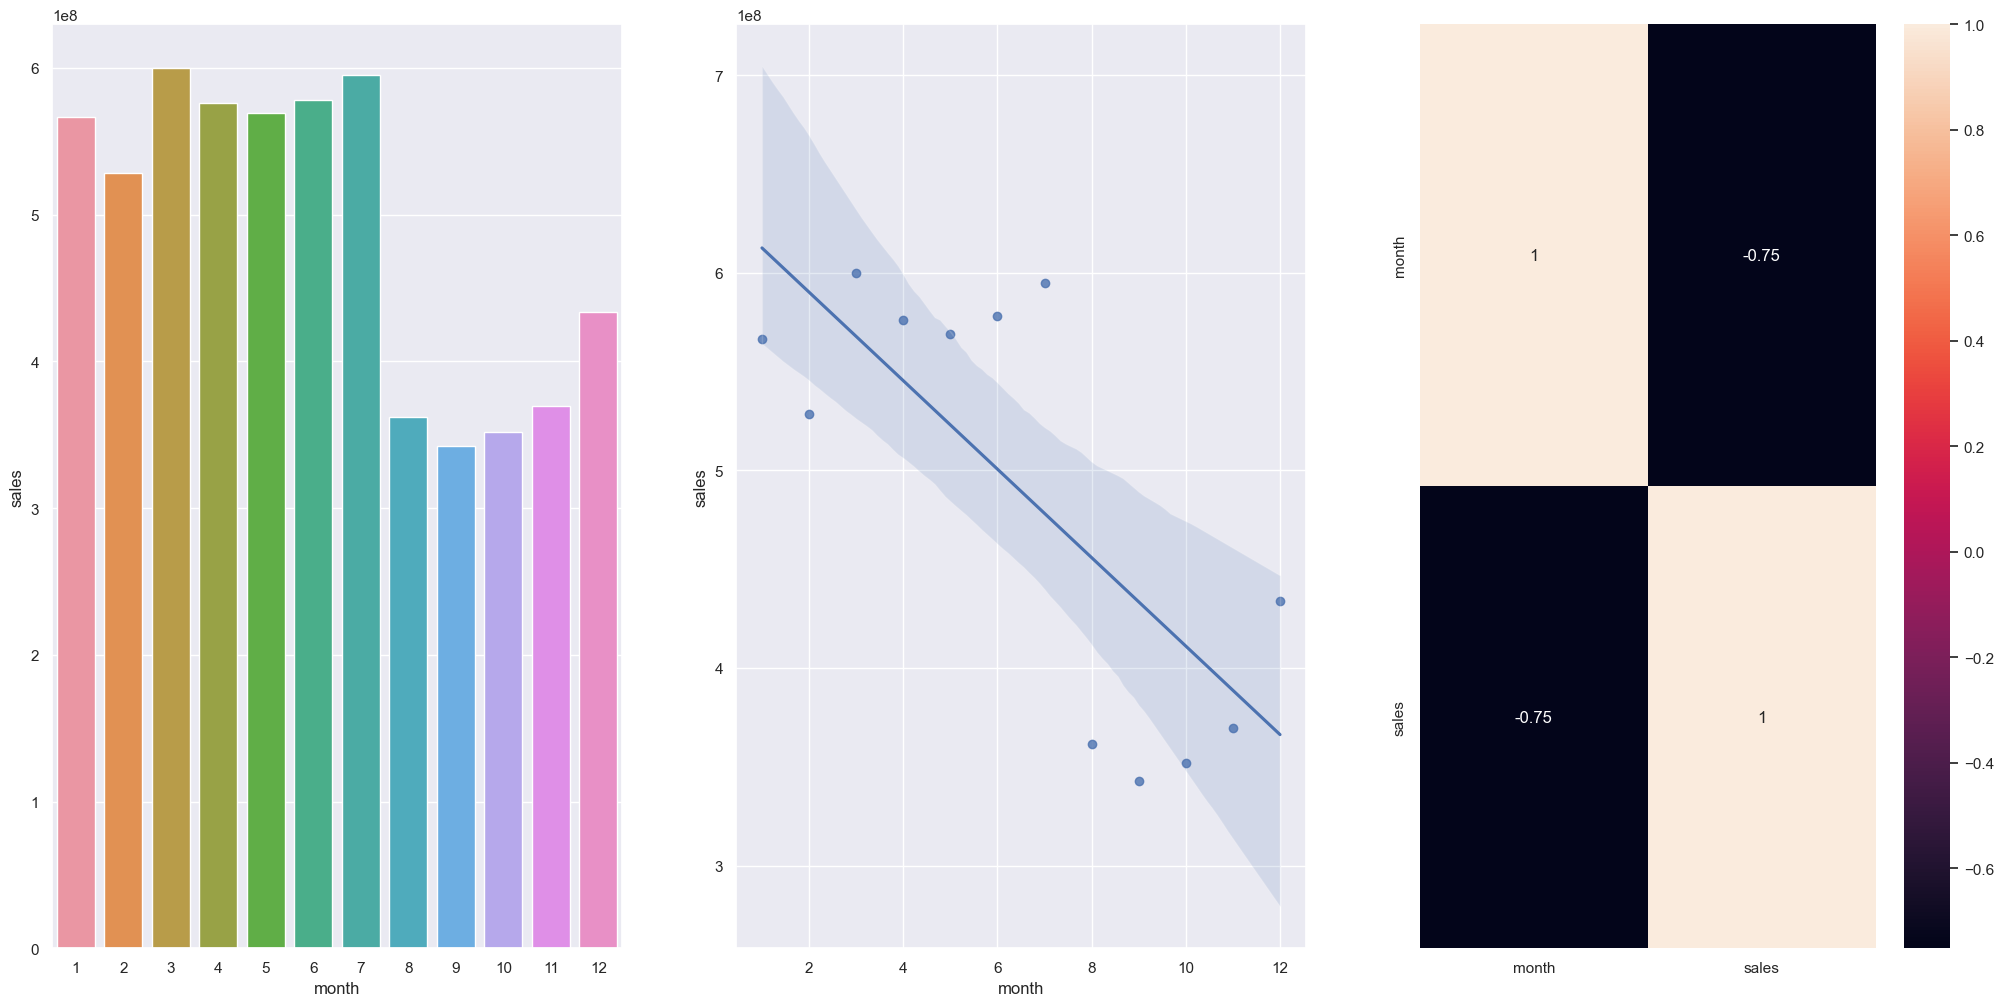

In [37]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method ='pearson'), annot=True);

### **10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

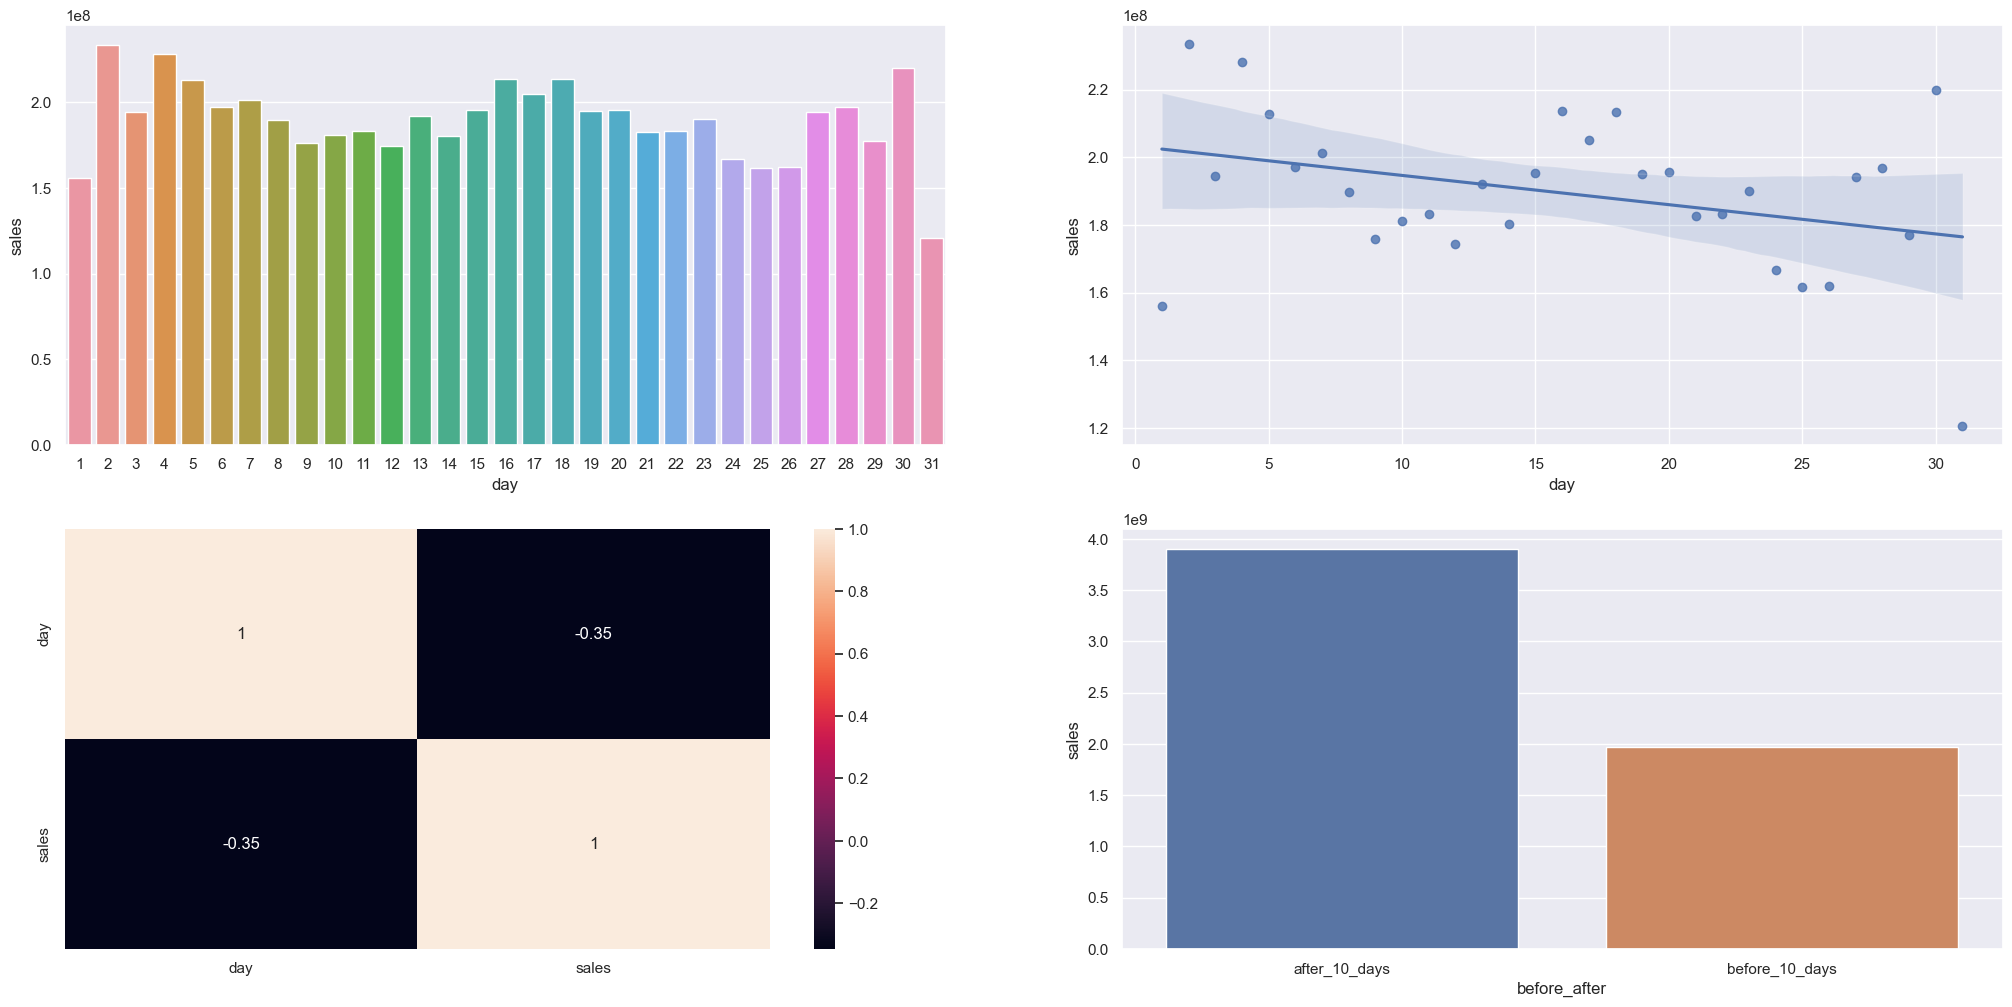

In [38]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method ='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana.


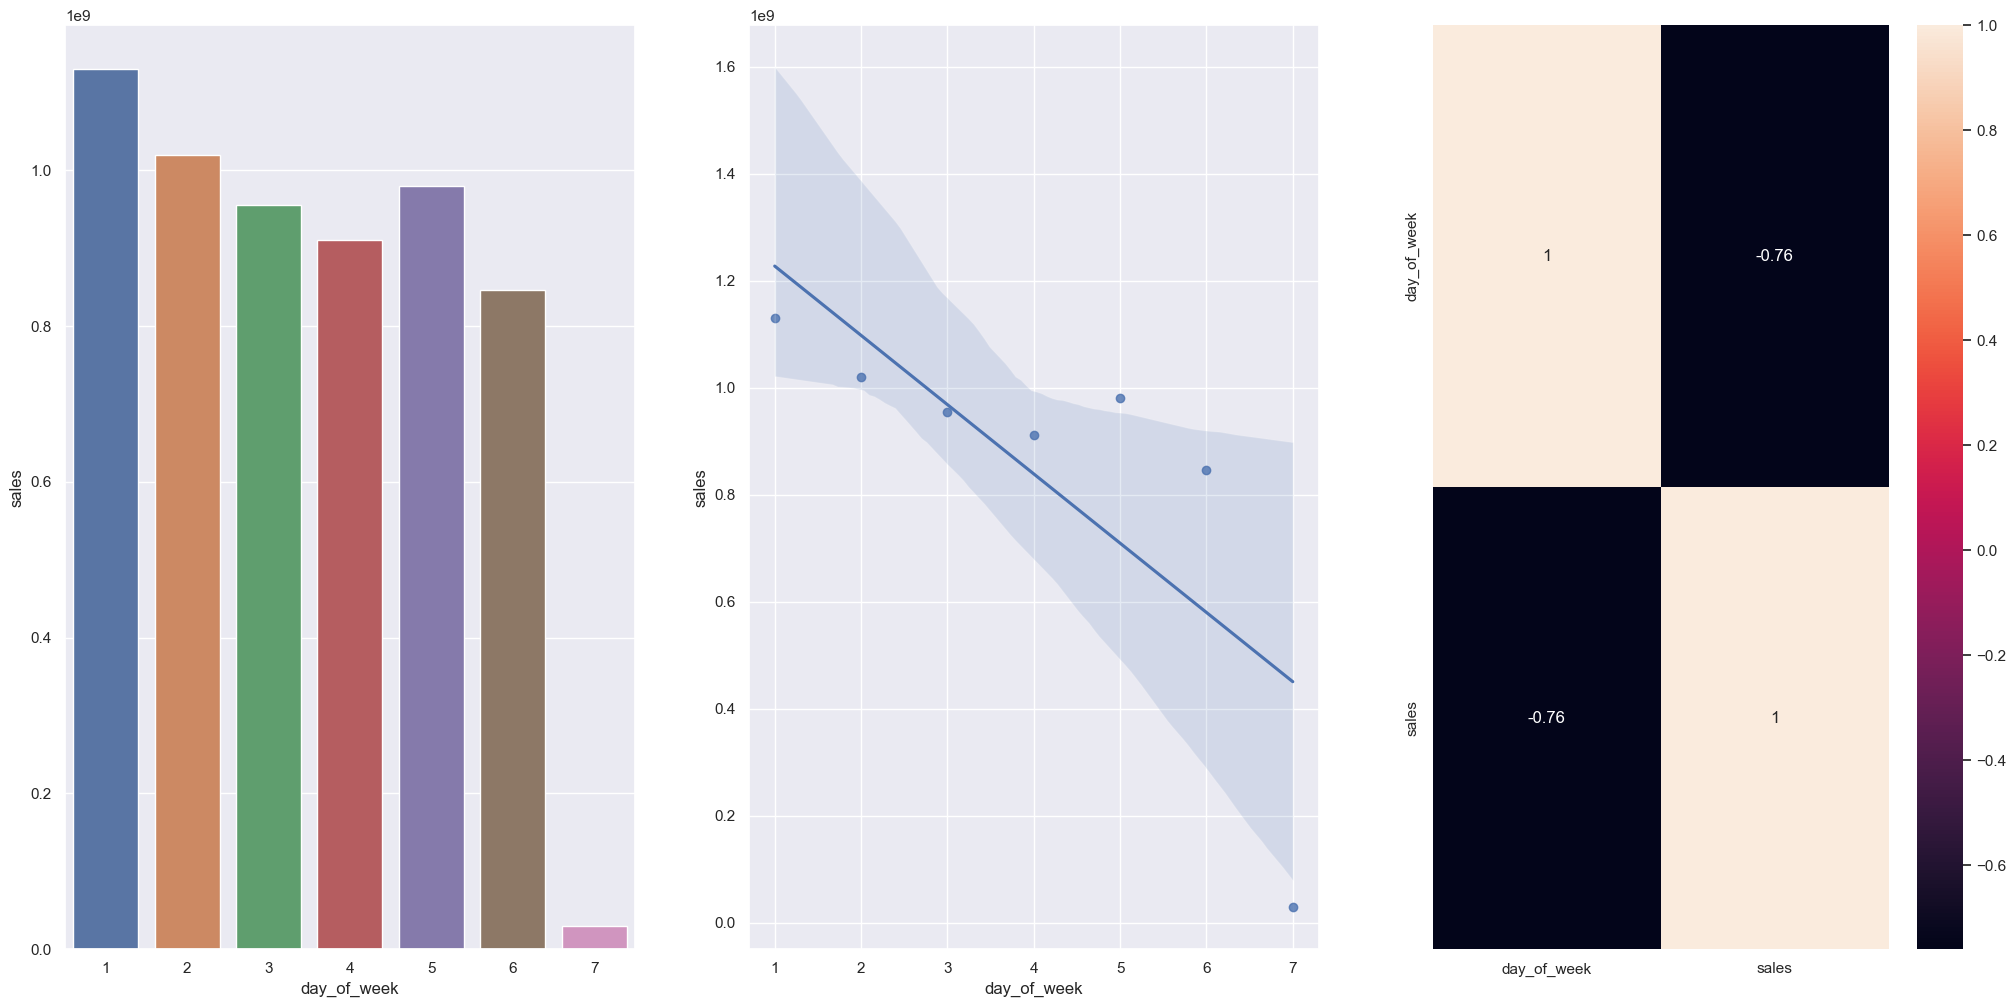

In [39]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method ='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADIRA** Lojas vendem mais durante os feriados escolares, exceto os meses de Julho e Agosto.

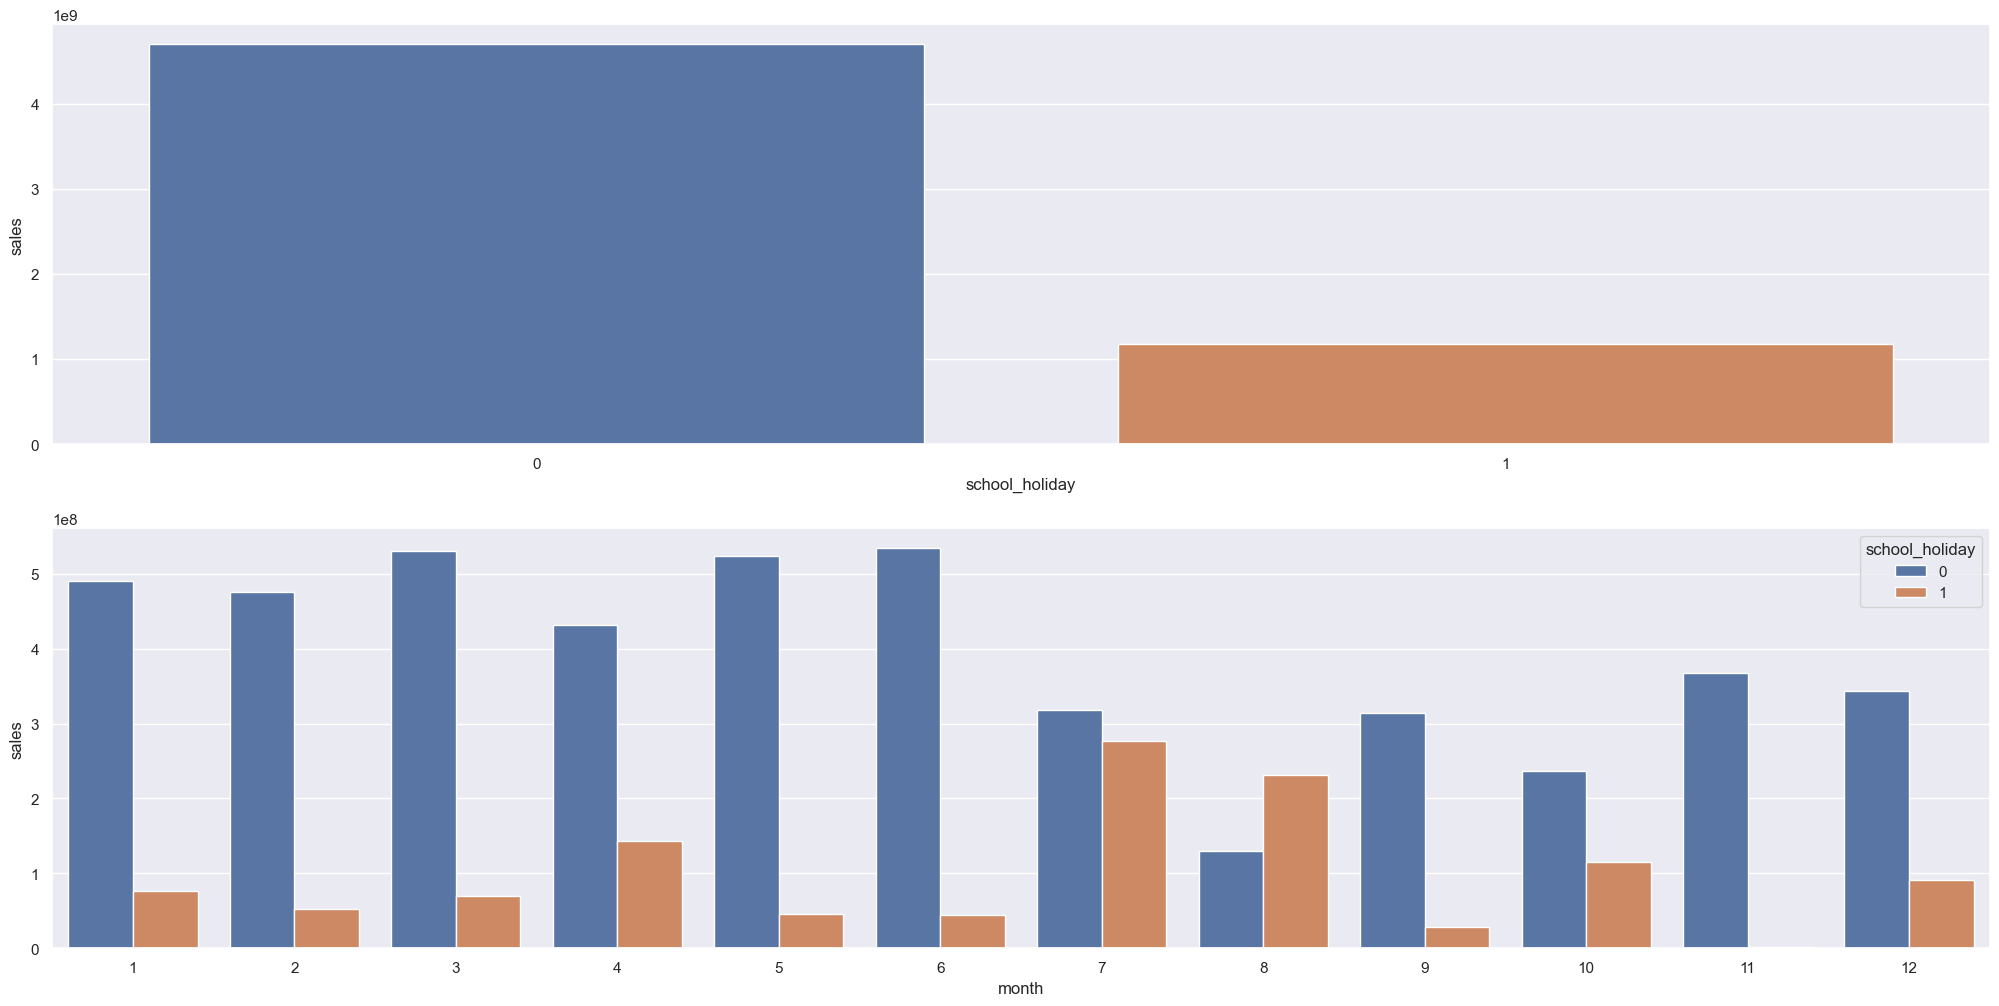

In [40]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);


### 4.2.1 Resumo das Hipoteses

In [41]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'],
       ['H1', 'Verdadeira', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

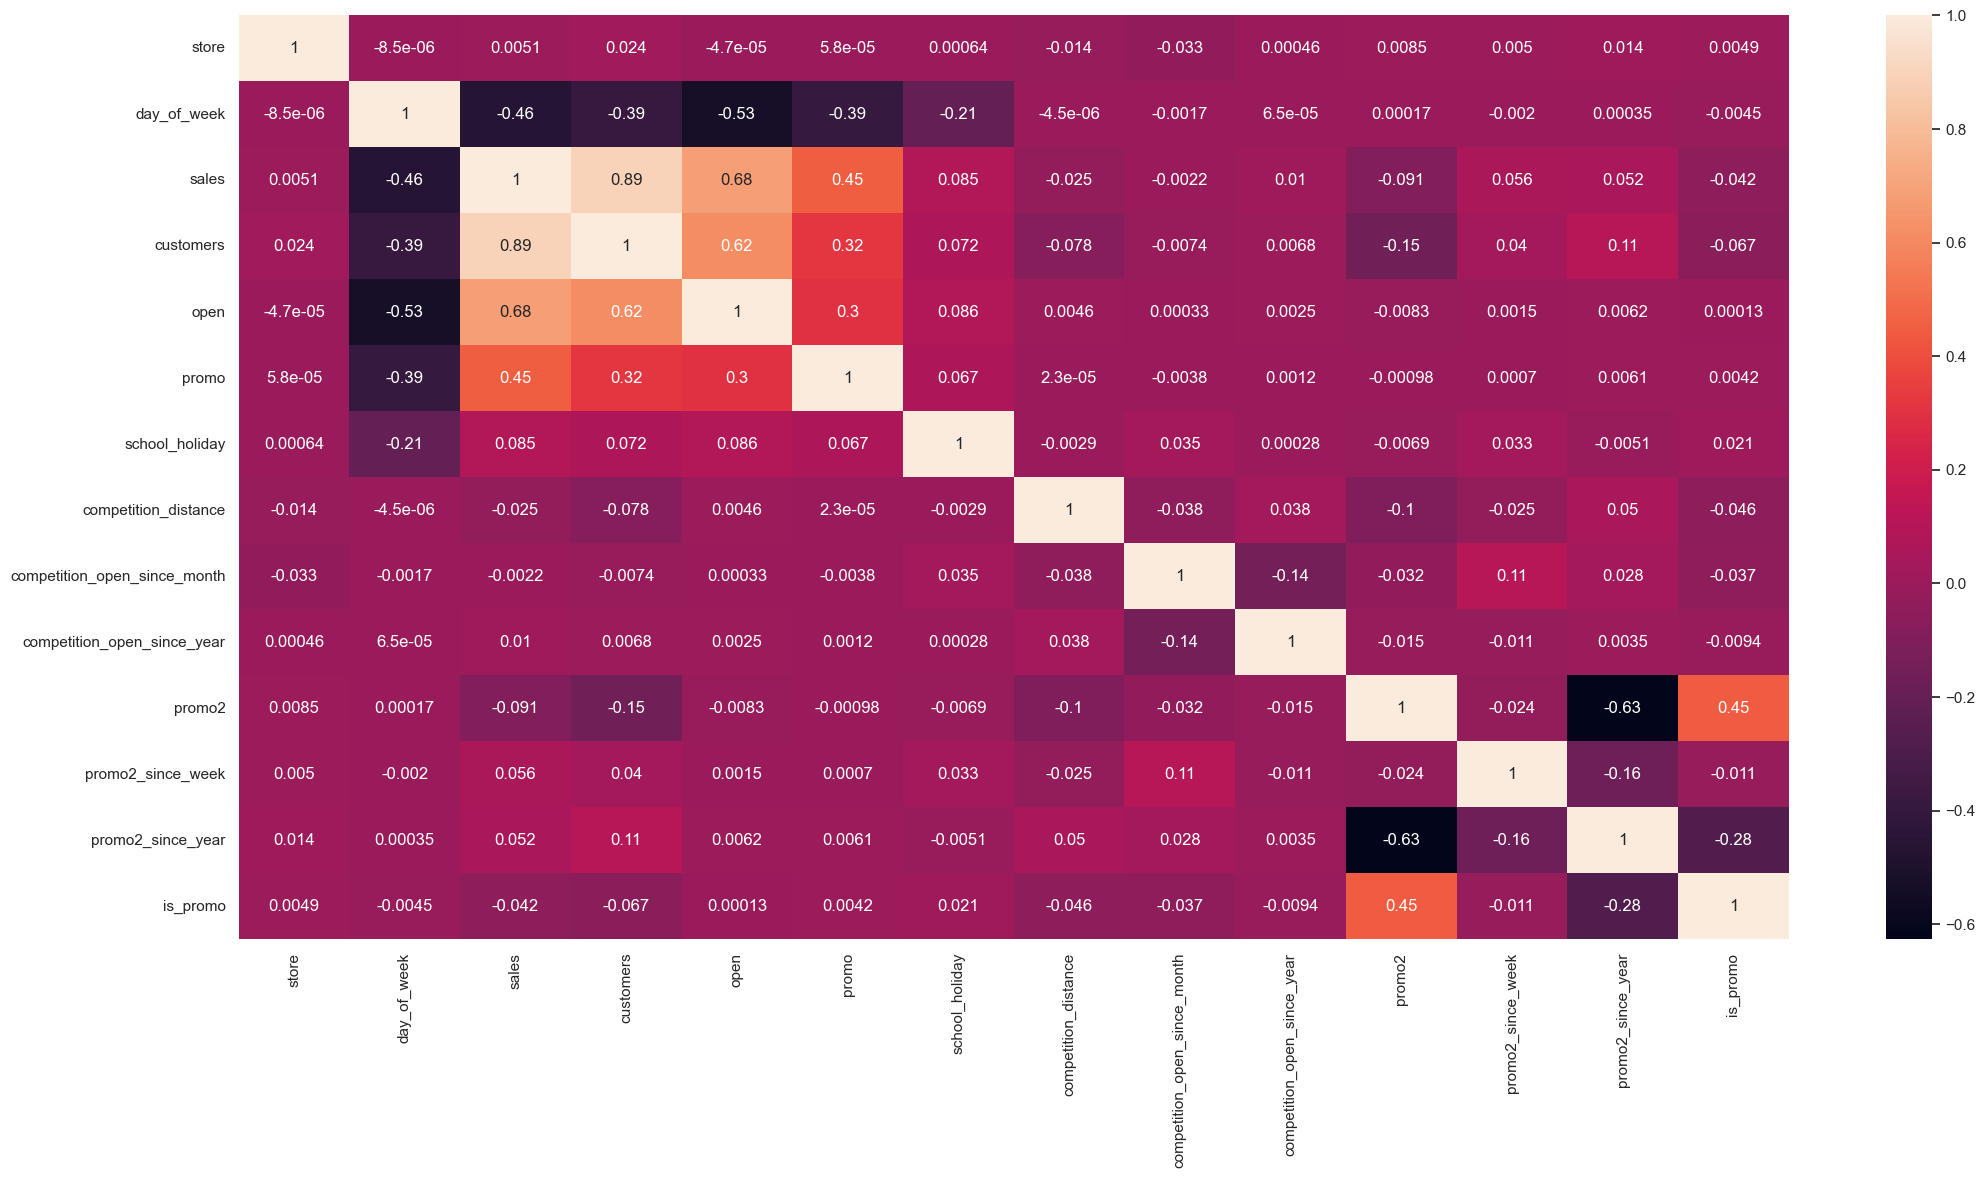

In [42]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

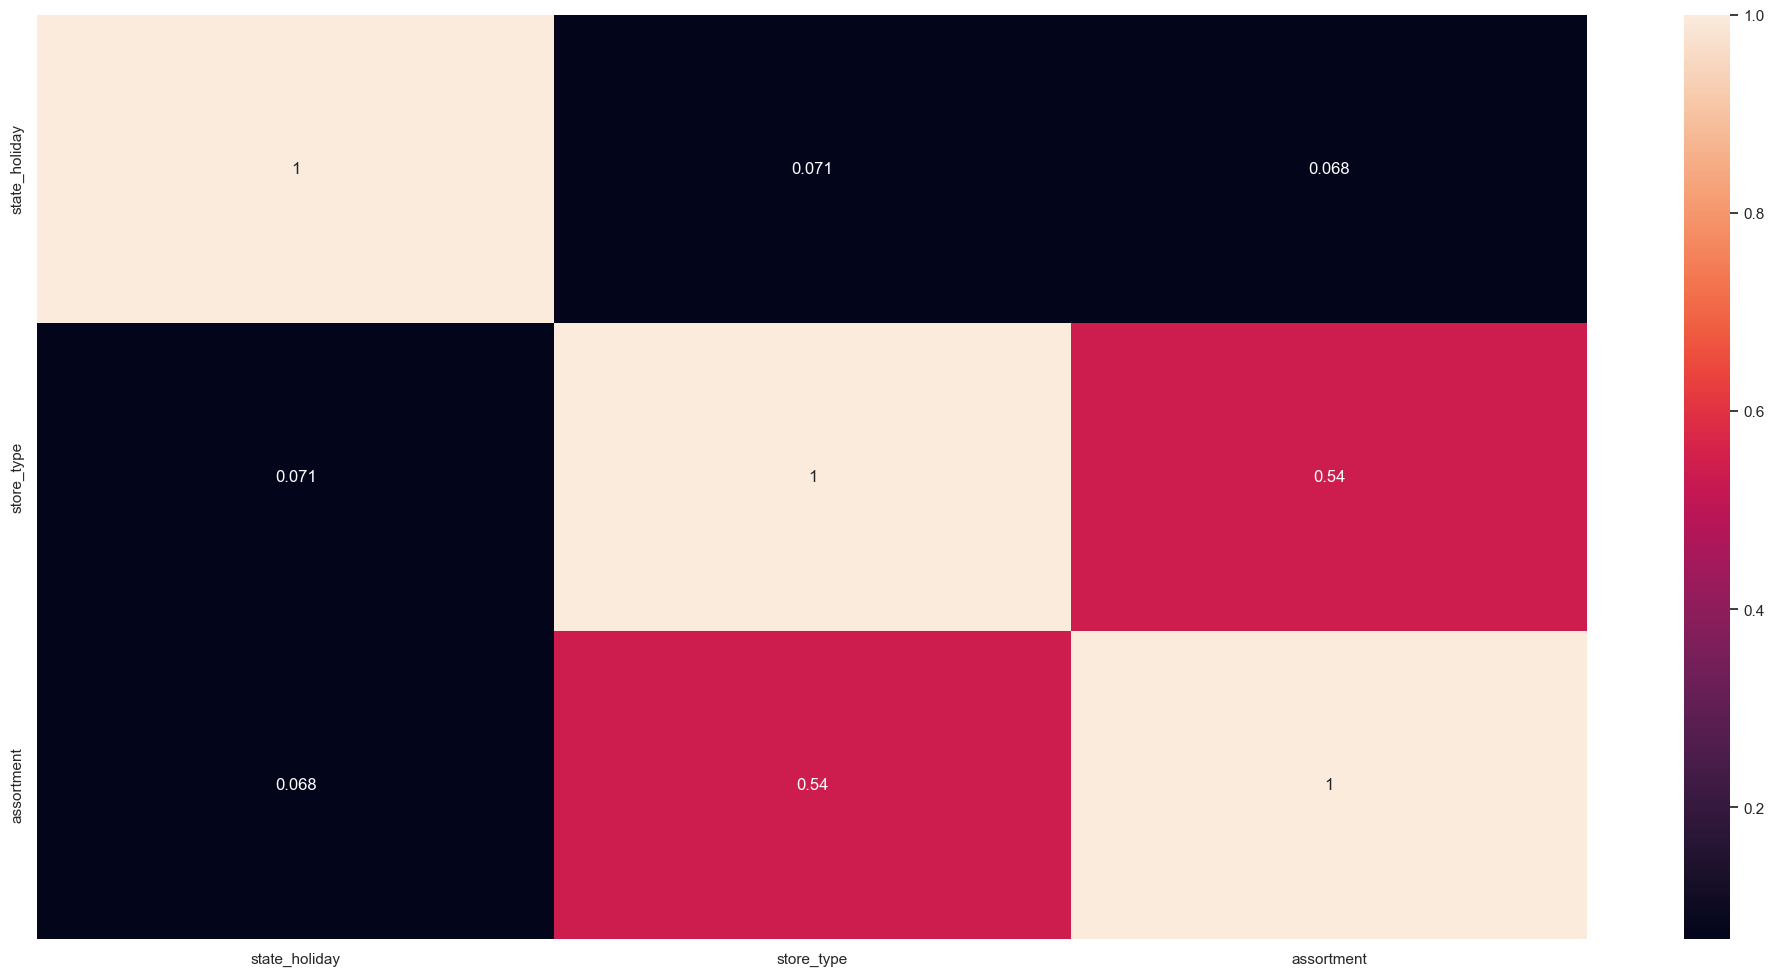

In [43]:
# Only categorical data
a = df4.select_dtypes( include ='object' )

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset
d= pd.DataFrame( {'state_holiday' : [a1, a2, a3],
               'store_type' : [a4, a5, a6],
               'assortment' : [a7, a8, a9]})

d = d.set_index( d.columns )

sns.heatmap(d, annot=True);

# 5.0 Data Preparation

In [44]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescalling

In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3 Transformação

### 5.3.1 Enconding

In [46]:
# state_holiday - One Hot Encodning
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

# store_type - Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [47]:
df5['sales'] = np.log1p( df5['sales'])

### 5.3.3 Nature Transformation

In [48]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7)))


In [49]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 Feature Selection

In [50]:
df6 = df5.copy()

## 6.1 Split Dataframe in to training and test dataset

In [51]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [52]:
cols_drop = ['week_of_year', 'day', 'month','day_of_week', 'promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [53]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [54]:
# Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test Dataset with last 6 weeks of sales
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}' .format(X_train['date'].min()))
print('Training Max Date: {}' .format(X_train['date'].max()))

print('\nTest Min Date: {}' .format(X_test['date'].min()))
print('Test Max Date: {}' .format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [55]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1  ).values
#y_train_n = y_train.values.ravel()
# define Random Forest
#rf = RandomForestRegressor( n_jobs=-1 )
# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [56]:
#cols_selected = boruta.support_.tolist()
## best features
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()
#not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [57]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_cos',
     'day_of_week_sin',
     'day_of_week_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling

In [58]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data preparation
x_training = X_train[ cols_selected_boruta_full]

## 7.1 Average Model

In [59]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']
# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,-0.131769,1835.135542


## 7.2 Linear Regression Model

In [60]:
# model 
lr = LinearRegression().fit( x_train, y_train) 
# prediction 
yhat_lr = lr.predict(x_test)
# performance 
lr_result = ml_error ( 'Linear Regression',  np.expm1(y_test),  np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1869.922218,-0.088894,2667.521087


### 7.2.1 Linear Regression Model - Cross Validation

In [61]:
lr_result_cv = cross_validation ( x_training, 5, 'Linear Regression', lr, verbose= False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.28 +/- 303.04,-0.05 +/- 0.07,2961.07 +/- 473.32


## 7.3 Linear Regression Regularized - Lasso

In [62]:
# model 
lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train) 

# prediction 
yhat_lrr = lrr.predict(x_test)

# performance 
lrr_result = ml_error ( 'Linear Regression - Lasso',  np.expm1(y_test),  np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.194994,-0.061532,2741.003247


### 7.3.1 Lasso - Cross Validation

In [63]:
lrr_result_cv = cross_validation ( x_training, 5, 'Lasso', lrr, verbose= False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.98 +/- 342.05,-0.01 +/- 0.05,3059.41 +/- 504.65


## 7.4 Random Forest Regressor

In [64]:
# # model 
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train) 

# # prediction 
# yhat_rf = rf.predict(x_test)

# # performance 
# rf_result = ml_error ( 'Random Forest Regressor',  np.expm1(y_test),  np.expm1(yhat_rf))
# rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [65]:
# rf_result_cv = cross_validation ( x_training, 5, 'Random Forest Regressor', rf, verbose= True )
# rf_result_cv

## 7.5 XGBoost Regressor

In [66]:
# # model 
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                               n_estimators=100,
#                               eta=0.01,
#                               max_depth=10,
#                               subsample=0.7,
#                               colsample_bytree=0.9).fit( x_train, y_train)

# # prediction 
# yhat_xgb = model_xgb.predict(x_test)

# # performance 
# xgb_result = ml_error( 'XGBoost Regressor',  np.expm1(y_test),  np.expm1(yhat_xgb) )
# xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [67]:
# xgb_result_cv = cross_validation ( x_training, 5, 'XGBoost Regressor', model_xgb, verbose= True )
# xgb_result_cv

## 7.6 Compare Model Performance 

### 7.6.1 Single Performance

In [68]:
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
# modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [69]:
# modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
# modelling_result_cv

# 8.0 Hyperparameter Fine Tunning

## 8.1 Random Search

In [70]:
warnings.filterwarnings('ignore')

In [71]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5 ,9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
#         }

# MAX_EVAL = 10

In [72]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # choose values for parameters randomly
#     hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#     print( hp )
#     # model 
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta= hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'] )
        
#     # performance 
#     result = cross_validation( x_training, 2, 'XBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat( [final_result, result] )
# final_result

## 8.2 Final Model

In [73]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [74]:
# model 
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta= param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )
  
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
    
# performance 
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,665.71475,0.00107,969.319349


In [75]:
mpe = mean_percentage_error(np.expm1( y_test ), np.expm1( yhat_xgb_tuned ))
mpe

0.09692104445859044

In [76]:
pickle.dump( model_xgb_tuned, open( '/Users/Breno/Documents/Repos/ds_em_producao/Projeto/DS_Em_Producao/model/model_rossman.pkl', 'wb' ) )

# 9.0 Tradução e Interpretação do Erro

In [98]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale 
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [105]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns ={0: 'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns ={0: 'MAPE'} )

# Merge

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on= 'store' )
df92 = pd.merge( df91, df9_aux3, how = 'inner', on = 'store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [109]:
df92.sort_values('MAPE', ascending= False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106220.000000,102869.111174,109570.888826,3350.888826,0.578619
908,909,240366.312500,232807.710279,247924.914721,7558.602221,0.519336
549,550,252444.203125,250820.116660,254068.289590,1624.086465,0.318888
875,876,203050.734375,199154.665442,206946.803308,3896.068933,0.284881
594,595,401009.625000,397536.762906,404482.487094,3472.862094,0.237394


<Axes: xlabel='store', ylabel='MAPE'>

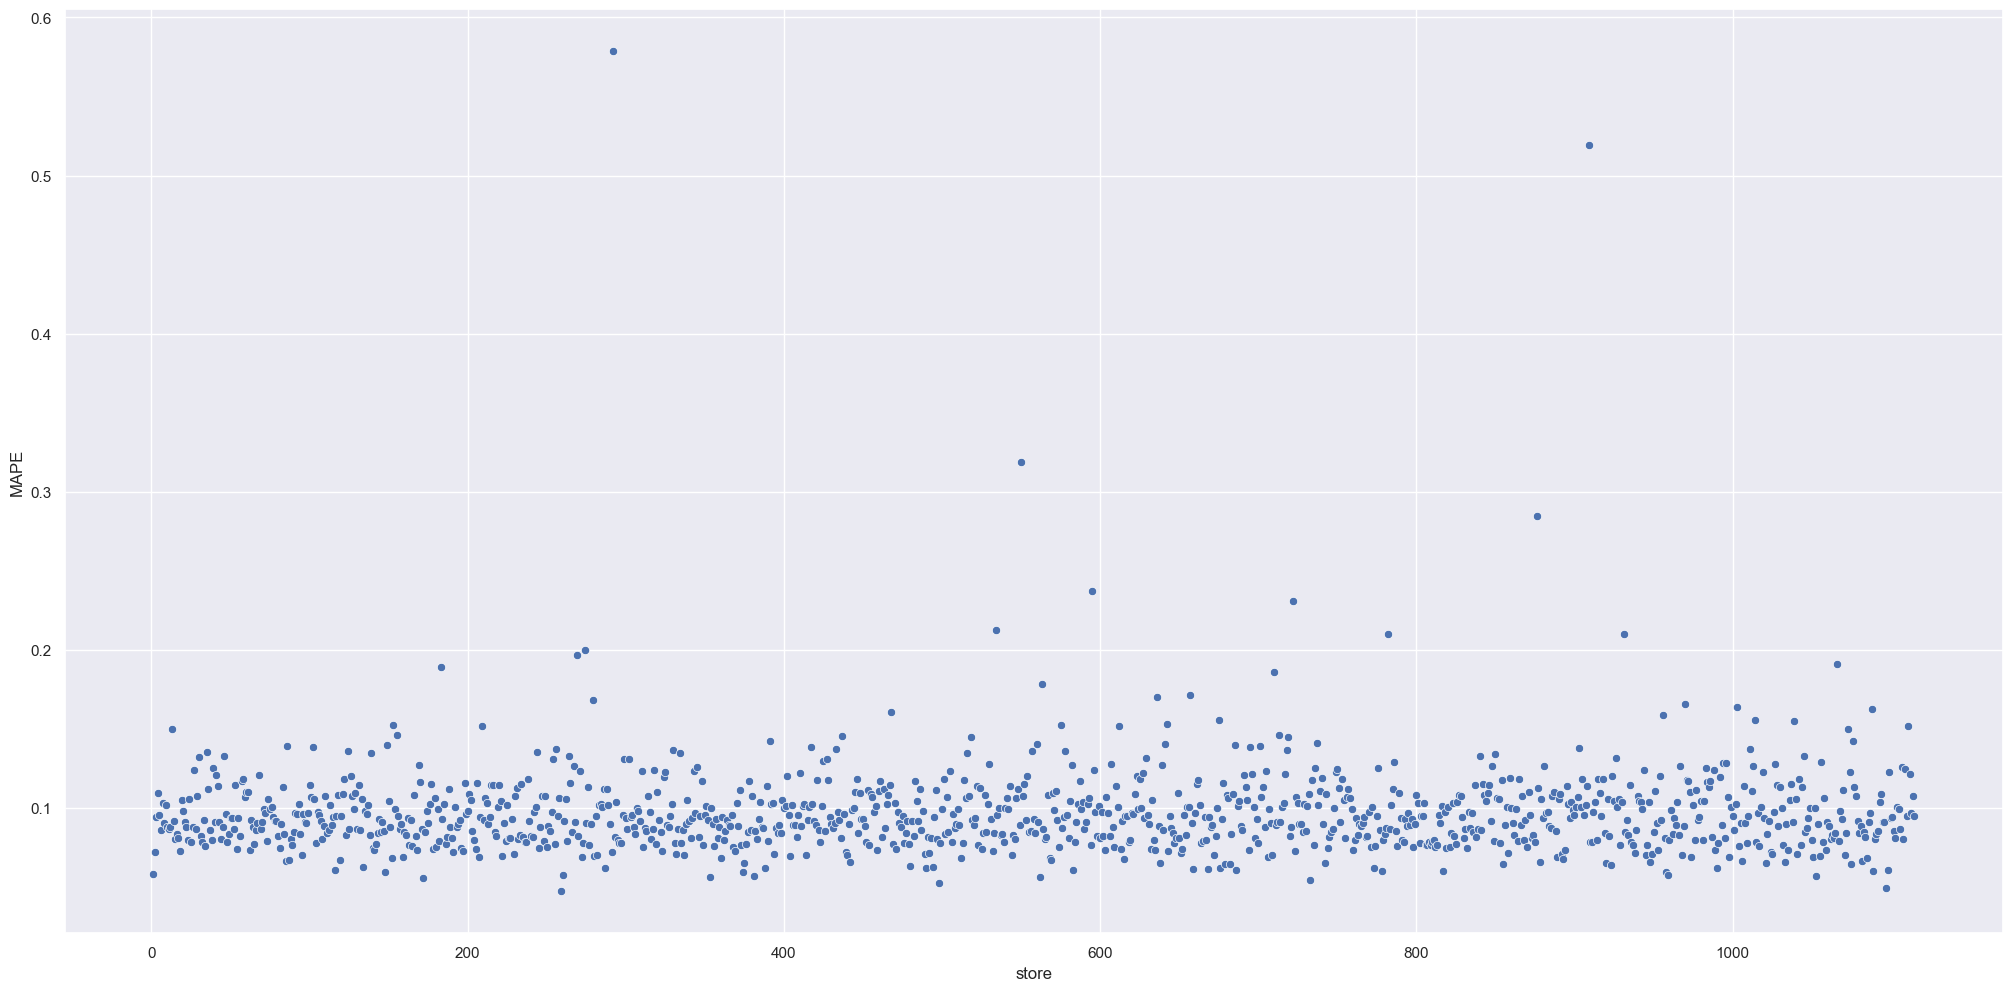

In [110]:
sns.scatterplot(x= 'store', y='MAPE', data=df92)

## 9.2 Total Performance

In [121]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario' ]].apply(lambda x: np.sum( x ), axis = 0).reset_index().rename( columns={'index': 'Scenarios', 0: 'Values'} )
df93['Values'] = df93['Values'].map(lambda x: 'R${:,.2f}'.format(x))
df93

,Scenarios,Values
0,predictions,"R$284,838,848.00"
1,worst_scenario,"R$284,092,537.01"
2,best_scenario,"R$285,585,148.85"


## 9.3 Machine Learning Performance

In [124]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

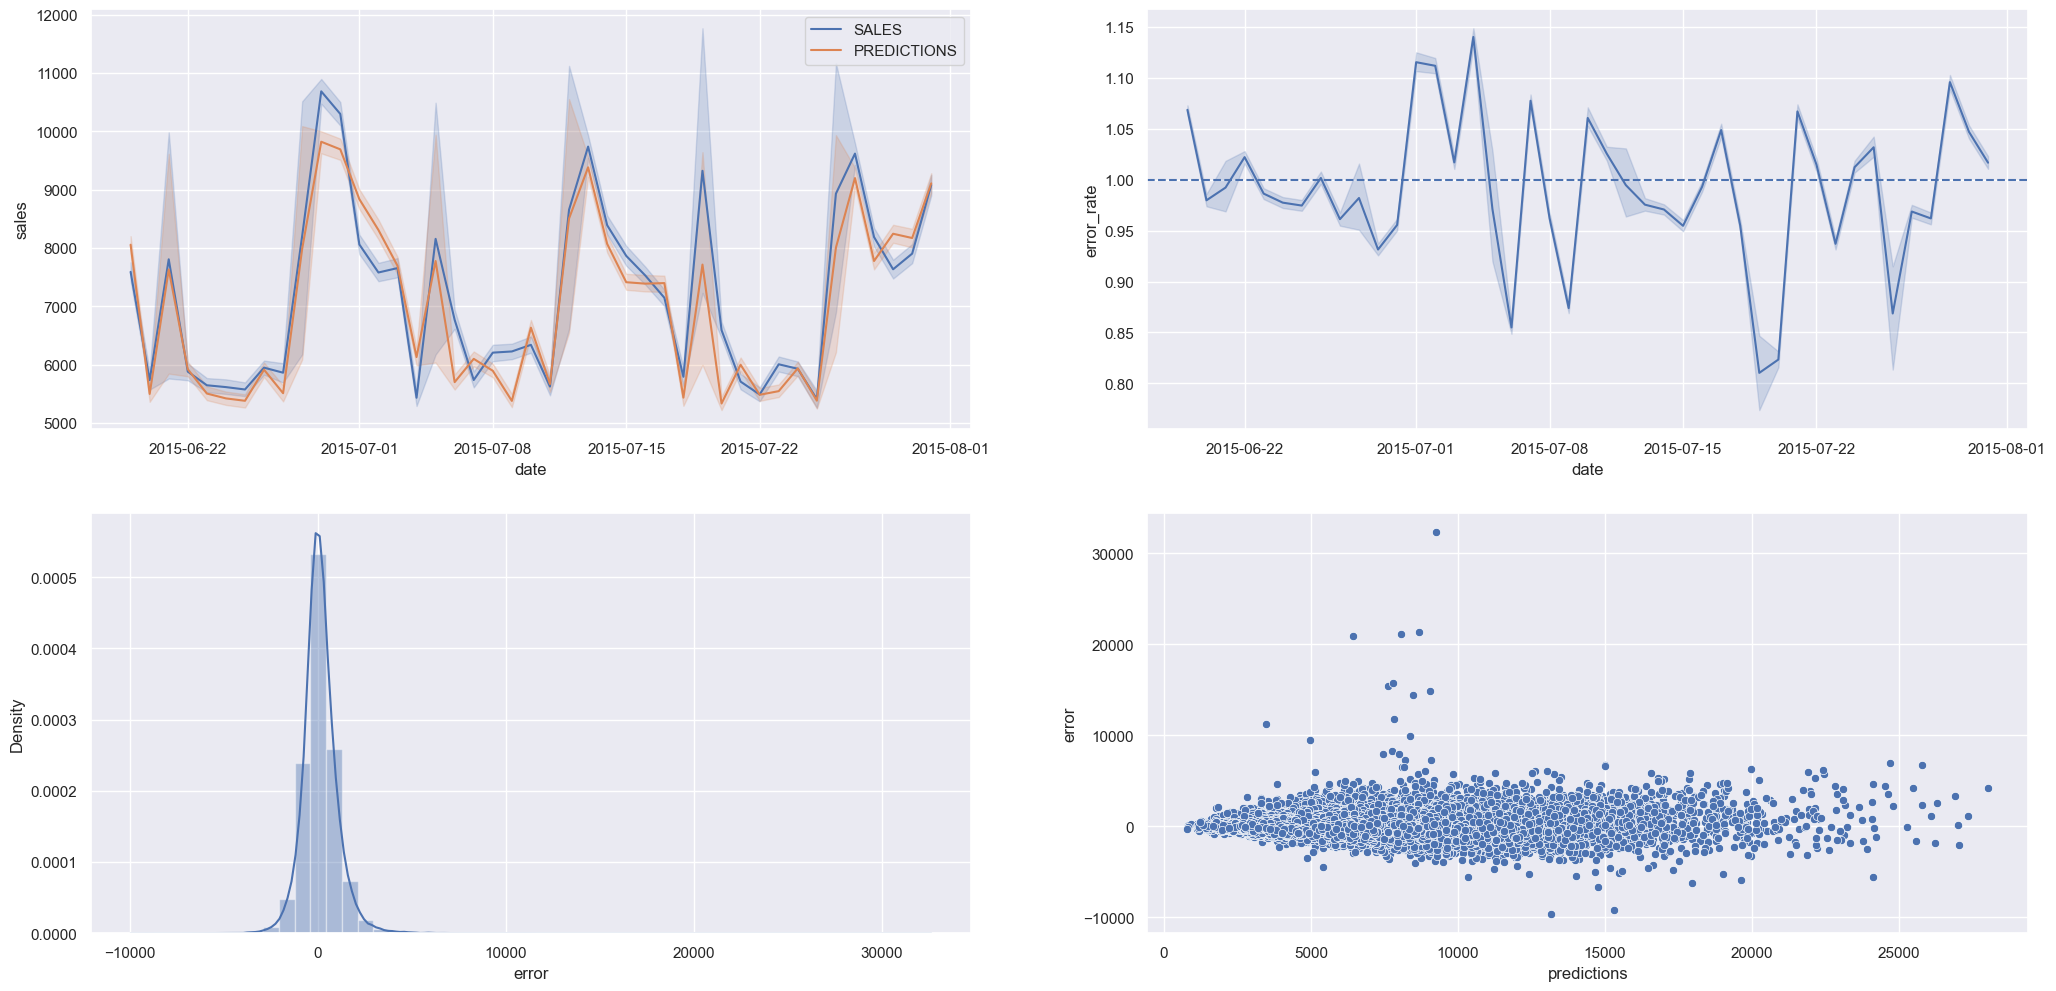

In [127]:
plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y= 'sales', data=df9, label ='SALES')
sns.lineplot(x = 'date', y= 'predictions', data=df9, label ='PREDICTIONS')


plt.subplot(2, 2, 2)
sns.lineplot(x = 'date', y= 'error_rate', data=df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])


plt.subplot(2, 2, 4)
sns.scatterplot( x= df9['predictions'], y = df9['error'])